# Projet 5 Segmentation de clients d'un site e-commerce

## 1 Nettoyage des données et pré-analyse 

####  Introduction

**Olist** souhaite recevoir pour ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

l' objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles.
Les équipes d’Olist attendent de l'aide pour comprendre les différents types d'utilisateurs


#### Mission

Je dois fournir à l’équipe marketing une description actionable de la segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.Cela se fera au travers de l 'utilisation des méthodes non supervisées pour regrouper des clients de profils similaires. Ces catégories pourront être utilisées par l’équipe Marketing pour mieux communiquer. concrétement il faut :
- préparer un  notebook avec des essais des différentes approches de modélisation.    
- préparer un notebook de simulation pour déterminer la fréquence nécessaire de mise à jour du modèle de segmentation, afin que celui-ci reste pertinent.  
- préparer une présentation pour un collègue afin d’obtenir ses retours sur votre approche.

#### Source
Pour cette mission, Olist a fourni une base de données anonymisée comportant des informations sur l’historique de commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients depuis janvier 2017.

### 1.1 Requirements¶
Pandas numpy

scikit-learn

matplotlib
seaborn

In [1]:
package_list=("pandas","numpy","matplotlib","scikit-learn","seaborn")

In [2]:
!python3 -V

Python 3.9.13


In [3]:
txt=!python -m pip freeze
check = lambda i :any([(pack in i) for pack in package_list])
txt=[i for i in txt if check(i)]
txt

['-atplotlib @ file:///C:/ci/matplotlib-suite_1613408055530/work',
 'matplotlib==3.7.1',
 'numpy @ file:///C:/ci/numpy_and_numpy_base_1618497418457/work',
 'numpydoc @ file:///tmp/build/80754af9/numpydoc_1605117425582/work',
 'pandas @ file:///C:/ci/pandas_1618365634936/work',
 'scikit-learn @ file:///C:/b/abs_7ck_bnw91r/croot/scikit-learn_1676911676133/work',
 'seaborn==0.12.2']

### 1.2 Imports

In [183]:
# builtin
import os,warnings,sys

# data
import pandas as pd
import numpy as np
import statistics as sta
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
# visualisation
import matplotlib as mtpl
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
from datetime import datetime, timedelta
from math import radians, cos, sin, asin, sqrt

### 1.3 Graphics and options¶

In [184]:
# warnings.filterxarnings('ignore'ou once
warnings.filterwarnings(action='ignore')
# nous désactivons les messages d'erreur
pd.set_option('display.max_columns', 200)
# Versions
print('Version des librairies utilisées :')

print('NumPy                 : ' + np.version.full_version)
print('Pandas                : ' + pd.__version__)
print('Python                : ' + sys.version)
print('Matplotlib            : ' + mtpl.__version__)
print('Seaborn               : ' + sns.__version__)


Version des librairies utilisées :
NumPy                 : 1.20.1
Pandas                : 1.2.4
Python                : 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]
Matplotlib            : 3.7.1
Seaborn               : 0.12.2


In [6]:
def correlation_matrice(df,corr_method):
    '''
pearson : standard correlation coefficient
kendall : Kendall Tau correlation coefficient
spearman :  Spearman rank correlation
''' 
    
    corr = df.corr(method=corr_method)
    
    mask=np.triu(np.ones_like(df.corr(),dtype=bool))
    sns.heatmap(df.corr(),mask=mask,center=0,cmap='RdBu',linewidths=1,annot=True,fmt='.2f',vmin=-1,vmax=1)
    plt.title('Heatmap des corrélations avec la méthode {}'.format(corr_method),fontsize=14,fontweight="bold")
    plt.show()

### 1.4 Chargement et nettoyage des jeux de données

In [7]:
path =('C:\\Users\\serge\\OneDrive\\Documents\\Documents\\DATA SCIENTIST\\P5\\')
filename='olist_customers_dataset.csv'

#### 1.4.1 Les clients

In [8]:
customers=pd.read_csv(path+filename)

In [9]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [10]:
customers.head(5)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [11]:
customers.nunique()

customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64

> Les clients :    
Il n'y a pas de valeurs nulles dans la table.  
Le customer_id sera utilisé lors des jointures. C'est un identifiant unique attribué à chaque commande  
customer_unique_id: identifiant client 

#### 1.4.2 La géolocalisation

In [12]:
filename='olist_geolocation_dataset.csv'
geolocations=pd.read_csv(path+filename)

In [13]:
geolocations.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [14]:
geolocations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geolocation_state            1000163 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 38.2+ MB


In [15]:
geolocations.duplicated().sum()

261831

In [16]:
geolocations.drop_duplicates(keep='first',inplace=True)

In [17]:
geolocations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 738332 entries, 0 to 1000161
Data columns (total 5 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   geolocation_zip_code_prefix  738332 non-null  int64  
 1   geolocation_lat              738332 non-null  float64
 2   geolocation_lng              738332 non-null  float64
 3   geolocation_city             738332 non-null  object 
 4   geolocation_state            738332 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 33.8+ MB


In [18]:
geolocations.nunique()

geolocation_zip_code_prefix     19015
geolocation_lat                717360
geolocation_lng                717613
geolocation_city                 8011
geolocation_state                  27
dtype: int64

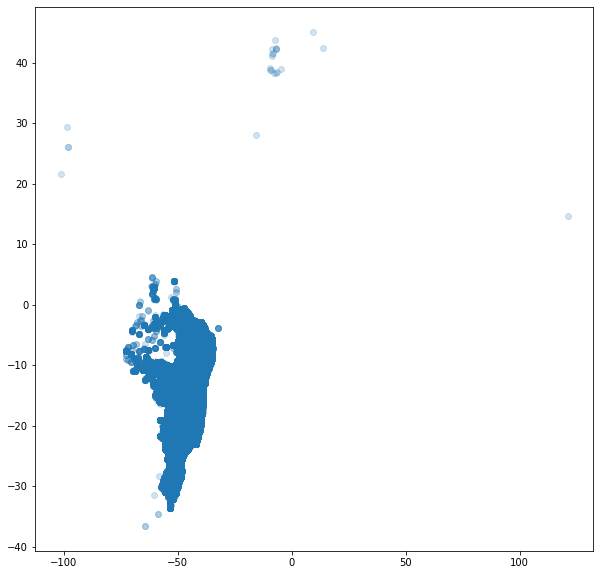

In [19]:
fig = plt.figure(figsize=(10, 10))

plt.scatter(x=geolocations["geolocation_lng"],
            y=geolocations["geolocation_lat"], alpha=0.2)

> la géolocalisation:  
> Pas de valeurs nulles mais il y avait des doublons qui ont été supprimés  
On peut utiliser zip_code_prefix pour jointure avec la table customers.  
Je vais prendre une moyenne des variables latitude et longitude en groupant par geolocation_zip_code_prefix

In [20]:
geos=geolocations.groupby(['geolocation_zip_code_prefix']).agg({'geolocation_lat':'mean','geolocation_lng':'mean',
                                                                'geolocation_city':'max','geolocation_state':'first'}).reset_index()


In [21]:
geos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19015 entries, 0 to 19014
Data columns (total 5 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   geolocation_zip_code_prefix  19015 non-null  int64  
 1   geolocation_lat              19015 non-null  float64
 2   geolocation_lng              19015 non-null  float64
 3   geolocation_city             19015 non-null  object 
 4   geolocation_state            19015 non-null  object 
dtypes: float64(2), int64(1), object(2)
memory usage: 742.9+ KB


In [22]:
geos.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1001,-23.550227,-46.634039,são paulo,SP
1,1002,-23.547657,-46.634991,são paulo,SP
2,1003,-23.549000,-46.635582,são paulo,SP
3,1004,-23.549829,-46.634792,são paulo,SP
4,1005,-23.549547,-46.636406,são paulo,SP


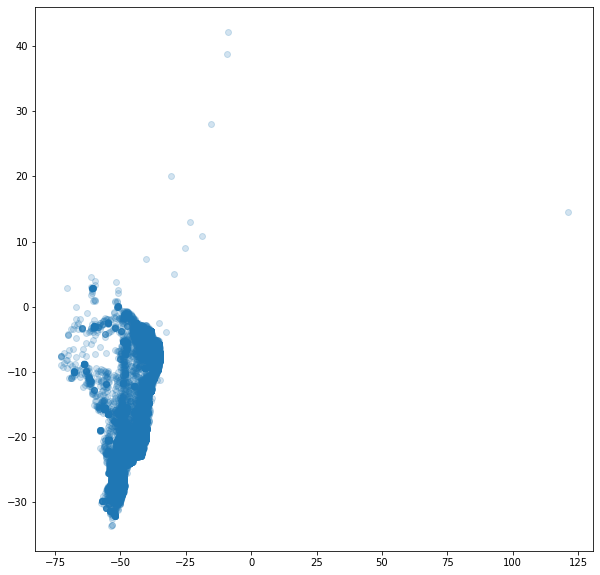

In [23]:
fig = plt.figure(figsize=(10, 10))

plt.scatter(x=geos["geolocation_lng"],
            y=geos["geolocation_lat"], alpha=0.2)

#### 1.4.3 Les articles

In [24]:
filename='olist_order_items_dataset.csv'
items=pd.read_csv(path+filename)

In [25]:
items.head(5)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [26]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [27]:
items.duplicated().sum()

0

In [28]:
items.nunique()

order_id               98666
order_item_id             21
product_id             32951
seller_id               3095
shipping_limit_date    93318
price                   5968
freight_value           6999
dtype: int64

> produits de la commande :   
> order_id : Identifiant unique de la commande  
order_item_id : Identifiant  des produits d'une même commande   
product_id : Identifiant unique du produit  
seller_id : Identifiant unique du vendeur  
price : Prix de la ligne de commande  
freight_value : Coût du fret  

#### 1.4.4 Les paiements

In [29]:
filename='olist_order_payments_dataset.csv'
payments=pd.read_csv(path+filename)

In [30]:
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [31]:
payments.duplicated().sum()

0

In [32]:
payments['payment_installments'].unique()

array([ 8,  1,  2,  3,  6,  5,  4, 10,  7, 12,  9, 13, 15, 24, 11, 18, 14,
       20, 21, 17, 22,  0, 16, 23], dtype=int64)

In [33]:
payments['payment_sequential'].unique()

array([ 1,  2,  4,  5,  3,  8,  6,  7, 10, 11, 17, 19, 27, 12,  9, 15, 13,
       14, 16, 25, 22, 26, 29, 28, 18, 21, 24, 23, 20], dtype=int64)

In [34]:
payments.head(5)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [35]:
payments['payment_type'].unique()

array(['credit_card', 'boleto', 'voucher', 'debit_card', 'not_defined'],
      dtype=object)

> le paiement :  
> order_id : identifiant de la commande  
payment_type : moyen de paiement utilisé (voucher =coupon prépayé et boleto = moyen de paiement en espèces très utilisé au Brésil )   
payment_sequential : séquence de paiement (une ligne par type de paiement)  
payment_installments : Nombre de versements    
payment_value : valeur du paiement  

#### 1.4.5 Les avis clients

In [36]:
filename='olist_order_reviews_dataset.csv'
reviews=pd.read_csv(path+filename)

In [37]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


In [38]:
reviews.duplicated().sum()

0

In [39]:
reviews.loc[reviews['review_comment_title'].isna()].sample(10)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
61908,5b8befaccafae537c5976791464ce45a,3ae126761938741db80da6163567b03d,5,NaN,NaN,2018-02-28 00:00:00,2018-03-01 01:04:35
19896,50b09c811df96a297bf8824830d01bc6,01ae5e4c5d2549f7c05000a2f5856c28,5,NaN,NaN,2017-11-17 00:00:00,2017-11-18 10:46:01
4840,b94d437f77146b671d654e8fe77dacfc,45f7d9a94705872dad55bc0c688f9cfd,5,NaN,"Produto de acordo com a descrição, compatível ...",2018-04-12 00:00:00,2018-04-15 03:55:05
95235,5e99633e8cba44bb1f5394d78fc139f4,7a9f1869ace3e3dabe41cef449258401,4,NaN,Produto entregue corretamente.\r\n,2017-09-16 00:00:00,2017-09-16 20:28:53
77955,a87661069575114fadd124c997fdddc4,24a670b13d0b287bf0e123c3010fd19c,4,NaN,NaN,2018-08-21 00:00:00,2018-08-21 21:47:36
22175,983d0409326cada6195d69b477be4265,5c3daac471748ba7152bf6760e8c12b8,5,NaN,NaN,2018-06-24 00:00:00,2018-06-24 14:56:26
94235,355e8b120f03582299f23bf92dbb51ca,10fd0add9c8dd2fc964bbd79ce10343b,5,NaN,NaN,2018-06-20 00:00:00,2018-06-22 17:54:58
44981,7d8346c47339a96c6119058230b4cdd6,fc0f2134e9a7cffb77d02c4754c264e8,5,NaN,NaN,2017-11-15 00:00:00,2017-11-15 19:46:08
54519,930c94a56d251ae1bda0d5ce4fa6b618,7ab5966251309fe2519cc5810895b2f7,5,NaN,muito bom,2018-02-03 00:00:00,2018-02-05 11:49:47
29848,d9eabac2c0e62d3ff06eedeaa1e52f67,5dedf97d50ce7b64e7270e21a30fc97d,4,NaN,NaN,2017-12-08 00:00:00,2017-12-11 11:09:12


On peut affecter une valeur pour remplacer les valeurs nan dans les 2 colonnes

In [40]:
reviews=reviews.fillna("no comment")

In [41]:
reviews.head(5)

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,no comment,no comment,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,no comment,no comment,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,no comment,no comment,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,no comment,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,no comment,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [42]:
reviews.nunique()

review_id                  98410
order_id                   98673
review_score                   5
review_comment_title        4528
review_comment_message     36160
review_creation_date         636
review_answer_timestamp    98248
dtype: int64

> Notes et Commentaires des clients :  
>order_id : identifiant commande                
review_score : note attribuée par le client  
review_comment_title: titre du commentaire laissé par le client    
review_comment_message : commentaire client  
review_creation_date : date de creation de l'avis client  
review_answer_timestamp : date de réponse 

#### 1.4.6 Les commandes

In [43]:
filename='olist_orders_dataset.csv'
orders=pd.read_csv(path+filename)

In [44]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [45]:
orders.duplicated().sum()

0

In [46]:
orders.nunique()

order_id                         99441
customer_id                      99441
order_status                         8
order_purchase_timestamp         98875
order_approved_at                90733
order_delivered_carrier_date     81018
order_delivered_customer_date    95664
order_estimated_delivery_date      459
dtype: int64

> les commandes:    
order_id: identifiant commande  
customer_id : identifiant client unique attribué à chaque commande(order_id)   
order_status : status de la commande    
order_purchase_timestamp : date et heure de commande  
order_approved_at : date et heure d'approbation  
order_delivered_carrier_date : date et heure prise en charge par le transporteur
order_delivered_customer_date :date et heure commande livrée  
order_estimated_delivery_date :date estimée de livraison chez le client

> Il y a des valeurs manquantes dans order_approved_at,order_delivered_carrier_date et order_delivered_customer_date.  
Intéressons nous à la colonne 'order_approved_at'

In [47]:
orders[orders.order_approved_at.isna()].head(5)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
1130,00b1cb0320190ca0daa2c88b35206009,3532ba38a3fd242259a514ac2b6ae6b6,canceled,2018-08-28 15:26:39,NaN,NaN,NaN,2018-09-12 00:00:00
1801,ed3efbd3a87bea76c2812c66a0b32219,191984a8ba4cbb2145acb4fe35b69664,canceled,2018-09-20 13:54:16,NaN,NaN,NaN,2018-10-17 00:00:00
1868,df8282afe61008dc26c6c31011474d02,aa797b187b5466bc6925aaaa4bb3bed1,canceled,2017-03-04 12:14:30,NaN,NaN,NaN,2017-04-10 00:00:00
2029,8d4c637f1accf7a88a4555f02741e606,b1dd715db389a2077f43174e7a675d07,canceled,2018-08-29 16:27:49,NaN,NaN,NaN,2018-09-13 00:00:00
2161,7a9d4c7f9b068337875b95465330f2fc,7f71ae48074c0cfec9195f88fcbfac55,canceled,2017-05-01 16:12:39,NaN,NaN,NaN,2017-05-30 00:00:00


In [48]:
# on supprime les lignes pour lesquelles la commande n'a pas été approuvée.
orders=orders.loc[~orders['order_approved_at'].isna()]
# nombre de lignes pour lesquelles la variable 'order_approved_at' n'est pas nan
orders.shape[0]

99281

 > Intéressons nous à la colonne 'order_delivered_carrier_date' 

In [49]:
print(' Il y a', orders['order_delivered_carrier_date'].isna().sum(),' valeurs manquantes dans order_delivered_carrier_date')

 Il y a 1637  valeurs manquantes dans order_delivered_carrier_date


> on peut regarder le status de ces commandes

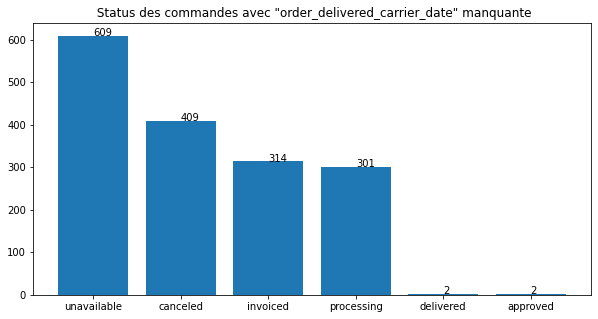

In [50]:
delivered_date_na= orders[orders.order_delivered_carrier_date.isna()]
plt.figure( figsize=(10,5))
plt.bar(x=delivered_date_na.order_status.value_counts().index, height=delivered_date_na.order_status.value_counts().values)
x=delivered_date_na.order_status.value_counts()
y=delivered_date_na.order_status.value_counts().values
for i in range(len(x)):
        plt.text(i, y[i], y[i])
plt.title(' Status des commandes avec "order_delivered_carrier_date" manquante')
plt.show()

je supprime celles dont le status est unavailable ou canceled

In [51]:
orders=orders.loc[~(orders['order_delivered_carrier_date'].isna() & orders['order_status'].isin(['canceled','unavailable']))]

In [52]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98263 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       98263 non-null  object
 1   customer_id                    98263 non-null  object
 2   order_status                   98263 non-null  object
 3   order_purchase_timestamp       98263 non-null  object
 4   order_approved_at              98263 non-null  object
 5   order_delivered_carrier_date   97644 non-null  object
 6   order_delivered_customer_date  96462 non-null  object
 7   order_estimated_delivery_date  98263 non-null  object
dtypes: object(8)
memory usage: 6.7+ MB


 > Vérifions si il reste des commandes avec le statut "canceled" ou "unavailable"

In [53]:
orders.loc[orders['order_status'].isin(['canceled','unavailable'])]

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
613,714fb133a6730ab81fa1d3c1b2007291,e3fe72696c4713d64d3c10afe71e75ed,canceled,2018-01-26 21:34:08,2018-01-26 21:58:39,2018-01-29 22:33:25,NaN,2018-02-22 00:00:00
1058,3a129877493c8189c59c60eb71d97c29,0913cdce793684e52bbfac69d87e91fd,canceled,2018-01-25 13:34:24,2018-01-25 13:50:20,2018-01-26 21:42:18,NaN,2018-02-23 00:00:00
2921,1950d777989f6a877539f53795b4c3c3,1bccb206de9f0f25adc6871a1bcf77b2,canceled,2018-02-19 19:48:52,2018-02-19 20:56:05,2018-02-20 19:57:13,2018-03-21 22:03:51,2018-03-09 00:00:00
5127,8a9cce19aa49e055f2babb81d5a71c40,f2676ef361959c938b35ecd32321adce,canceled,2018-02-01 10:04:20,2018-02-03 02:52:42,2018-02-05 20:41:28,NaN,2018-02-23 00:00:00
5449,c1049eef89915c6beb3604bf3d6588d7,ed16865bcadcea1a00a928bf418a74bf,canceled,2018-02-05 23:08:11,2018-02-05 23:29:26,2018-02-09 22:13:01,NaN,2018-03-07 00:00:00
...,...,...,...,...,...,...,...,...
94175,c9f06c1229ec7cd4ec9aed55d434b499,fa89053140d09081b3a3a4608a74c083,canceled,2018-02-05 20:26:29,2018-02-05 20:49:48,2018-02-06 19:49:32,NaN,2018-03-01 00:00:00
94399,2c45c33d2f9cb8ff8b1c86cc28c11c30,de4caa97afa80c8eeac2ff4c8da5b72e,canceled,2016-10-09 15:39:56,2016-10-10 10:40:49,2016-10-14 10:40:50,2016-11-09 14:53:50,2016-12-08 00:00:00
96300,1def7af24cb7182497acfd953f6dd88b,b35c38c2cd6a72b58cb104154d9782e4,canceled,2017-12-21 09:22:36,2017-12-23 02:12:37,2018-01-30 19:28:55,NaN,2018-02-20 00:00:00
97207,716bcd6dfe99970baf4aed2083136ed8,42715bff8f22b8dc62e5055b1e9fef7e,canceled,2018-02-03 13:37:35,2018-02-03 13:50:26,2018-02-05 19:59:59,NaN,2018-03-01 00:00:00


 > nous les enlevons pour la suite de l'analyse.

In [54]:
orders=orders.loc[~orders['order_status'].isin(['canceled','unavailable'])]

In [55]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98188 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       98188 non-null  object
 1   customer_id                    98188 non-null  object
 2   order_status                   98188 non-null  object
 3   order_purchase_timestamp       98188 non-null  object
 4   order_approved_at              98188 non-null  object
 5   order_delivered_carrier_date   97569 non-null  object
 6   order_delivered_customer_date  96456 non-null  object
 7   order_estimated_delivery_date  98188 non-null  object
dtypes: object(8)
memory usage: 6.7+ MB


 > il y a des commandes qui n'ont pas encore été livrées chez le transporteurs, ni chez les clients. Nous les conservons.

In [56]:
orders.nunique()

order_id                         98188
customer_id                      98188
order_status                         5
order_purchase_timestamp         97636
order_approved_at                89760
order_delivered_carrier_date     80939
order_delivered_customer_date    95644
order_estimated_delivery_date      447
dtype: int64

#### 1.4.7 Les produits

In [57]:
filename='olist_products_dataset.csv'
products=pd.read_csv(path+filename)

In [58]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32341 non-null  object 
 2   product_name_lenght         32341 non-null  float64
 3   product_description_lenght  32341 non-null  float64
 4   product_photos_qty          32341 non-null  float64
 5   product_weight_g            32949 non-null  float64
 6   product_length_cm           32949 non-null  float64
 7   product_height_cm           32949 non-null  float64
 8   product_width_cm            32949 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [59]:
products.duplicated().sum()

0

> Les produits:  
product_id : identifiant produit  
product_category_name : nom de la catégorie du produit    
colonnes descriptives du produits

In [60]:
products.loc[products['product_category_name'].isna()]

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
105,a41e356c76fab66334f36de622ecbd3a,NaN,NaN,NaN,NaN,650.0,17.0,14.0,12.0
128,d8dee61c2034d6d075997acef1870e9b,NaN,NaN,NaN,NaN,300.0,16.0,7.0,20.0
145,56139431d72cd51f19eb9f7dae4d1617,NaN,NaN,NaN,NaN,200.0,20.0,20.0,20.0
154,46b48281eb6d663ced748f324108c733,NaN,NaN,NaN,NaN,18500.0,41.0,30.0,41.0
197,5fb61f482620cb672f5e586bb132eae9,NaN,NaN,NaN,NaN,300.0,35.0,7.0,12.0
...,...,...,...,...,...,...,...,...,...
32515,b0a0c5dd78e644373b199380612c350a,NaN,NaN,NaN,NaN,1800.0,30.0,20.0,70.0
32589,10dbe0fbaa2c505123c17fdc34a63c56,NaN,NaN,NaN,NaN,800.0,30.0,10.0,23.0
32616,bd2ada37b58ae94cc838b9c0569fecd8,NaN,NaN,NaN,NaN,200.0,21.0,8.0,16.0
32772,fa51e914046aab32764c41356b9d4ea4,NaN,NaN,NaN,NaN,1300.0,45.0,16.0,45.0


In [61]:
products.loc[products['product_weight_g'].isna()]

,product_id,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
8578,09ff539a621711667c43eba6a3bd8466,bebes,60.0,865.0,3.0,NaN,NaN,NaN,NaN
18851,5eb564652db742ff8f28759cd8d2652a,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


> il y a des produits qui n'ont ni catégorie, ni  nom , ni description , ni photo mais qui ont des dimensions , des poids.
Il y a également 2 produits sans dimensions ni poids.
Nous les conservons et complétons les valeurs manquantes par "n.d" non disponible

In [62]:
products['product_category_name']=products['product_category_name'].fillna('n.d')
products=products.fillna(0)

In [63]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   product_category_name       32951 non-null  object 
 2   product_name_lenght         32951 non-null  float64
 3   product_description_lenght  32951 non-null  float64
 4   product_photos_qty          32951 non-null  float64
 5   product_weight_g            32951 non-null  float64
 6   product_length_cm           32951 non-null  float64
 7   product_height_cm           32951 non-null  float64
 8   product_width_cm            32951 non-null  float64
dtypes: float64(7), object(2)
memory usage: 2.3+ MB


In [64]:
products.nunique()

product_id                    32951
product_category_name            74
product_name_lenght              67
product_description_lenght     2961
product_photos_qty               20
product_weight_g               2204
product_length_cm               100
product_height_cm               103
product_width_cm                 96
dtype: int64

#### 1.4.8 Les vendeurs

In [65]:
filename='olist_sellers_dataset.csv'
sellers=pd.read_csv(path+filename)

In [66]:
sellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB


In [67]:
sellers.duplicated().sum()

0

In [68]:
sellers.nunique()

seller_id                 3095
seller_zip_code_prefix    2246
seller_city                611
seller_state                23
dtype: int64

> Les vendeurs :  
ce jeu de données ne sera pas pris en compte car l'étude porte sur les clients  


#### Les catégories de produits traduites en anglais

In [69]:
filename='product_category_name_translation.csv'
translations=pd.read_csv(path+filename)

In [70]:
translations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB


In [71]:
translations.duplicated().sum()

0

In [72]:
translations.nunique()

product_category_name            71
product_category_name_english    71
dtype: int64

> traduction des catégories de produits  
Cette table ne sera pas utilisée car il vaut mieux conservé les catégories dans la langue du client.

### 1.5 Jointures des différents jeux de données

#### 1.5.1  jointure des jeux de données customers et orders 

In [73]:
customers_orders = customers.merge(orders, on='customer_id',how='inner')   

In [74]:
customers_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98188 entries, 0 to 98187
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   customer_id                    98188 non-null  object
 1   customer_unique_id             98188 non-null  object
 2   customer_zip_code_prefix       98188 non-null  int64 
 3   customer_city                  98188 non-null  object
 4   customer_state                 98188 non-null  object
 5   order_id                       98188 non-null  object
 6   order_status                   98188 non-null  object
 7   order_purchase_timestamp       98188 non-null  object
 8   order_approved_at              98188 non-null  object
 9   order_delivered_carrier_date   97569 non-null  object
 10  order_delivered_customer_date  96456 non-null  object
 11  order_estimated_delivery_date  98188 non-null  object
dtypes: int64(1), object(11)
memory usage: 9.7+ MB


In [75]:
# nombre de clients qui n'ont pas commandé !!!
customers.loc[~customers['customer_id'].isin(customers_orders['customer_id'].unique())]['customer_id'].count()                          

1253

In [76]:
customers_orders['order_status'].unique()

array(['delivered', 'invoiced', 'shipped', 'processing', 'approved'],
      dtype=object)

Je conserve uniquement les commandes livrées (status == 'delivered' & 'order_delivered_customer_date'. NotNull) 

In [77]:
customers_orders=customers_orders.loc[(customers_orders['order_status']=="delivered")&\
                                      (customers_orders['order_delivered_customer_date'].notnull())]

In [78]:
# supprimer colonnes non conservées pour la suite
list_to_del=['order_status','order_approved_at','order_delivered_carrier_date','order_estimated_delivery_date']
customers_orders.drop(columns=list_to_del,inplace=True)

In [79]:
# format date sur les variables contenant des dates
customers_orders['order_purchase_timestamp']=pd.to_datetime(customers_orders['order_purchase_timestamp'].astype('datetime64[ns]'))
customers_orders['order_delivered_customer_date']=pd.to_datetime(customers_orders['order_delivered_customer_date'].astype('datetime64[ns]'))



In [80]:
customers_orders.sample()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_purchase_timestamp,order_delivered_customer_date
84209,6675a20f961c46c11c1ac4cfa5facc41,5145c62d477b346951d4958a4e897104,48730,conceicao do coite,BA,549a57fb0fe960c37b957ad69afeeba1,2018-03-15 14:25:44,2018-04-13 19:27:38


#### 1.5.2 jointure du dataset obtenu avec la table items

In [81]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  object 
 3   seller_id            112650 non-null  object 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 6.0+ MB


In [82]:
items_=customers_orders.merge(items, on='order_id',how='inner')   

In [83]:
items_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110174 entries, 0 to 110173
Data columns (total 14 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    110174 non-null  object        
 1   customer_unique_id             110174 non-null  object        
 2   customer_zip_code_prefix       110174 non-null  int64         
 3   customer_city                  110174 non-null  object        
 4   customer_state                 110174 non-null  object        
 5   order_id                       110174 non-null  object        
 6   order_purchase_timestamp       110174 non-null  datetime64[ns]
 7   order_delivered_customer_date  110174 non-null  datetime64[ns]
 8   order_item_id                  110174 non-null  int64         
 9   product_id                     110174 non-null  object        
 10  seller_id                      110174 non-null  object        
 11  

In [84]:
# colonnes non conservées
list_to_del=['seller_id','shipping_limit_date']
items_.drop(columns=list_to_del,inplace=True)

In [85]:
items_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110174 entries, 0 to 110173
Data columns (total 12 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    110174 non-null  object        
 1   customer_unique_id             110174 non-null  object        
 2   customer_zip_code_prefix       110174 non-null  int64         
 3   customer_city                  110174 non-null  object        
 4   customer_state                 110174 non-null  object        
 5   order_id                       110174 non-null  object        
 6   order_purchase_timestamp       110174 non-null  datetime64[ns]
 7   order_delivered_customer_date  110174 non-null  datetime64[ns]
 8   order_item_id                  110174 non-null  int64         
 9   product_id                     110174 non-null  object        
 10  price                          110174 non-null  float64       
 11  

#### 1.5.3  jointure du dataset obtenu  avec la table  payments 

In [86]:
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


Nous allons ajouter une colonne qui comptera le nombre de moyens de paiement différents utilisés pour le réglement de la commande et une colonne qui totalisera le nombre d'échéances de la commande

In [87]:
payments_grby=payments.groupby(by="order_id").agg(
    {"payment_sequential": 'count',
     "payment_installments": 'sum'})


In [88]:
payments.loc[payments['payment_installments']==5].sample(10)

,order_id,payment_sequential,payment_type,payment_installments,payment_value
81045,59e53c261681312bd398bcac254262e8,1,credit_card,5,138.50
87923,a5739097eb2ca76c5777ee5c16b5d3c0,1,credit_card,5,724.69
56891,0a8724bf3ecd49bce712851bbbecaf35,1,credit_card,5,53.10
54603,8bd3b0d275f7d6d8686ddb86f88a71f6,1,credit_card,5,104.94
65076,867df4f53d01780cfb562ce2a7275bd2,1,credit_card,5,59.10
58013,1b51db19999eb3bb34b405f52fdf9b13,1,credit_card,5,112.55
60245,4932f0177140a9a8b32264ac6f41ac5f,1,credit_card,5,74.49
78581,d40e7a80365572af2e27d31a9cf79169,1,credit_card,5,264.08
91314,76f73aa1ed8a90212ad2c15403e265aa,1,credit_card,5,118.93
28069,a3f03305225173eb1cf3ea5eeb32e583,1,credit_card,5,51.84


In [89]:
payments_grby.head()

,payment_sequential,payment_installments
order_id,,
00010242fe8c5a6d1ba2dd792cb16214,1,2
00018f77f2f0320c557190d7a144bdd3,1,3
000229ec398224ef6ca0657da4fc703e,1,5
00024acbcdf0a6daa1e931b038114c75,1,2
00042b26cf59d7ce69dfabb4e55b4fd9,1,3


In [90]:
payments_grby.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99440 entries, 00010242fe8c5a6d1ba2dd792cb16214 to fffe41c64501cc87c801fd61db3f6244
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   payment_sequential    99440 non-null  int64
 1   payment_installments  99440 non-null  int64
dtypes: int64(2)
memory usage: 2.3+ MB


In [91]:
# On ne prend en compte que les commandes qui ont fait l'objet de payement (inner)
items_ = pd.merge(items_, payments_grby,
                       how="inner",
                       on="order_id")
items_ = items_.rename(columns={
    "payment_sequential": "payment_sequential_nbre",
    "payment_installments": "payment_installments_sum"})

In [92]:
items_.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110171 entries, 0 to 110170
Data columns (total 14 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    110171 non-null  object        
 1   customer_unique_id             110171 non-null  object        
 2   customer_zip_code_prefix       110171 non-null  int64         
 3   customer_city                  110171 non-null  object        
 4   customer_state                 110171 non-null  object        
 5   order_id                       110171 non-null  object        
 6   order_purchase_timestamp       110171 non-null  datetime64[ns]
 7   order_delivered_customer_date  110171 non-null  datetime64[ns]
 8   order_item_id                  110171 non-null  int64         
 9   product_id                     110171 non-null  object        
 10  price                          110171 non-null  float64       
 11  

#### 1.5.4 jointure du dataset obtenu avec la table reviews

In [93]:
reviews.nunique()

review_id                  98410
order_id                   98673
review_score                   5
review_comment_title        4528
review_comment_message     36160
review_creation_date         636
review_answer_timestamp    98248
dtype: int64

Je vais ajouter une variable qui indiquera si la commande a été nommée (oui =True et non =False)
et une variable qui donnera le score moyen de la commande.

In [94]:
reviews_grby = reviews.groupby("order_id").agg({
    "review_id": "count",
    "review_score": "last"})

In [95]:
items_ = pd.merge(items_, reviews_grby,
                       how="left",
                       on="order_id")
items_ = items_.rename(columns={
    "review_id": "note","review_score":"score"})
items_["note"] = np.where(items_["note"] == 1,
                                      True, False)
items_.head(5)


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_purchase_timestamp,order_delivered_customer_date,order_item_id,product_id,price,freight_value,payment_sequential_nbre,payment_installments_sum,note,score
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,2017-05-25 10:35:35,1,a9516a079e37a9c9c36b9b78b10169e8,124.99,21.88,1,2,True,4.0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,2018-01-29 12:41:19,1,4aa6014eceb682077f9dc4bffebc05b0,289.00,46.48,1,8,True,5.0
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45,2018-06-14 17:58:51,1,bd07b66896d6f1494f5b86251848ced7,139.94,17.79,1,7,True,5.0
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,2018-03-13 16:06:38,2018-03-28 16:04:25,1,a5647c44af977b148e0a3a4751a09e2e,149.94,23.36,1,1,True,5.0
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 09:51:30,2018-08-09 20:55:48,1,9391a573abe00141c56e38d84d7d5b3b,230.00,22.25,1,8,True,5.0


####  1.5.5 Jointure du dataset obtenu avec la table products

In [96]:
df = pd.merge(items_, products,
               how="left",
               on="product_id")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110171 entries, 0 to 110170
Data columns (total 24 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    110171 non-null  object        
 1   customer_unique_id             110171 non-null  object        
 2   customer_zip_code_prefix       110171 non-null  int64         
 3   customer_city                  110171 non-null  object        
 4   customer_state                 110171 non-null  object        
 5   order_id                       110171 non-null  object        
 6   order_purchase_timestamp       110171 non-null  datetime64[ns]
 7   order_delivered_customer_date  110171 non-null  datetime64[ns]
 8   order_item_id                  110171 non-null  int64         
 9   product_id                     110171 non-null  object        
 10  price                          110171 non-null  float64       
 11  

## 2. Analyse exploratoire

Nous pouvons afficher le nombre de commandes contenant un seul produit.

In [97]:
nb_achat=df.groupby(by='customer_id', as_index=False)['order_id'].count()
nb_achat.loc[nb_achat['order_id']==1].count()['order_id']

86822

Il y a une commande comportant 21 produits

In [98]:
nb_achat.loc[nb_achat['order_id']==21].head()

,customer_id,order_id
95047,fc3d1daec319d62d49bfb5e1f83123e9,21


In [99]:
df.loc[df['customer_id']=='fc3d1daec319d62d49bfb5e1f83123e9']

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_purchase_timestamp,order_delivered_customer_date,order_item_id,product_id,price,freight_value,payment_sequential_nbre,payment_installments_sum,note,score,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
52185,fc3d1daec319d62d49bfb5e1f83123e9,4546caea018ad8c692964e3382debd19,5882,sao paulo,SP,8272b63d03f5f79c56e9e4120aec44ef,2017-07-16 18:19:25,2017-07-31 18:03:02,1,270516a3f41dc035aa87d220228f844c,1.2,7.89,1,2,True,1.0,beleza_saude,45.0,232.0,3.0,800.0,21.0,4.0,15.0
52186,fc3d1daec319d62d49bfb5e1f83123e9,4546caea018ad8c692964e3382debd19,5882,sao paulo,SP,8272b63d03f5f79c56e9e4120aec44ef,2017-07-16 18:19:25,2017-07-31 18:03:02,2,05b515fdc76e888aada3c6d66c201dff,1.2,7.89,1,2,True,1.0,beleza_saude,45.0,231.0,3.0,800.0,21.0,4.0,15.0
52187,fc3d1daec319d62d49bfb5e1f83123e9,4546caea018ad8c692964e3382debd19,5882,sao paulo,SP,8272b63d03f5f79c56e9e4120aec44ef,2017-07-16 18:19:25,2017-07-31 18:03:02,3,05b515fdc76e888aada3c6d66c201dff,1.2,7.89,1,2,True,1.0,beleza_saude,45.0,231.0,3.0,800.0,21.0,4.0,15.0
52188,fc3d1daec319d62d49bfb5e1f83123e9,4546caea018ad8c692964e3382debd19,5882,sao paulo,SP,8272b63d03f5f79c56e9e4120aec44ef,2017-07-16 18:19:25,2017-07-31 18:03:02,4,05b515fdc76e888aada3c6d66c201dff,1.2,7.89,1,2,True,1.0,beleza_saude,45.0,231.0,3.0,800.0,21.0,4.0,15.0
52189,fc3d1daec319d62d49bfb5e1f83123e9,4546caea018ad8c692964e3382debd19,5882,sao paulo,SP,8272b63d03f5f79c56e9e4120aec44ef,2017-07-16 18:19:25,2017-07-31 18:03:02,5,05b515fdc76e888aada3c6d66c201dff,1.2,7.89,1,2,True,1.0,beleza_saude,45.0,231.0,3.0,800.0,21.0,4.0,15.0
52190,fc3d1daec319d62d49bfb5e1f83123e9,4546caea018ad8c692964e3382debd19,5882,sao paulo,SP,8272b63d03f5f79c56e9e4120aec44ef,2017-07-16 18:19:25,2017-07-31 18:03:02,6,05b515fdc76e888aada3c6d66c201dff,1.2,7.89,1,2,True,1.0,beleza_saude,45.0,231.0,3.0,800.0,21.0,4.0,15.0
52191,fc3d1daec319d62d49bfb5e1f83123e9,4546caea018ad8c692964e3382debd19,5882,sao paulo,SP,8272b63d03f5f79c56e9e4120aec44ef,2017-07-16 18:19:25,2017-07-31 18:03:02,7,05b515fdc76e888aada3c6d66c201dff,1.2,7.89,1,2,True,1.0,beleza_saude,45.0,231.0,3.0,800.0,21.0,4.0,15.0
52192,fc3d1daec319d62d49bfb5e1f83123e9,4546caea018ad8c692964e3382debd19,5882,sao paulo,SP,8272b63d03f5f79c56e9e4120aec44ef,2017-07-16 18:19:25,2017-07-31 18:03:02,8,05b515fdc76e888aada3c6d66c201dff,1.2,7.89,1,2,True,1.0,beleza_saude,45.0,231.0,3.0,800.0,21.0,4.0,15.0
52193,fc3d1daec319d62d49bfb5e1f83123e9,4546caea018ad8c692964e3382debd19,5882,sao paulo,SP,8272b63d03f5f79c56e9e4120aec44ef,2017-07-16 18:19:25,2017-07-31 18:03:02,9,05b515fdc76e888aada3c6d66c201dff,1.2,7.89,1,2,True,1.0,beleza_saude,45.0,231.0,3.0,800.0,21.0,4.0,15.0
52194,fc3d1daec319d62d49bfb5e1f83123e9,4546caea018ad8c692964e3382debd19,5882,sao paulo,SP,8272b63d03f5f79c56e9e4120aec44ef,2017-07-16 18:19:25,2017-07-31 18:03:02,10,05b515fdc76e888aada3c6d66c201dff,1.2,7.89,1,2,True,1.0,beleza_saude,45.0,231.0,3.0,800.0,21.0,4.0,15.0


 Nous pouvons afficher la répartition des commandes  en %  en fonction du nombre de produits de la commande .

In [100]:
nb_achat['order_id'].value_counts(normalize=True)

1     0.900130
2     0.076626
3     0.013530
4     0.005132
5     0.002001
6     0.001980
7     0.000228
8     0.000083
10    0.000083
12    0.000052
11    0.000041
9     0.000031
14    0.000021
15    0.000021
20    0.000021
13    0.000010
21    0.000010
Name: order_id, dtype: float64

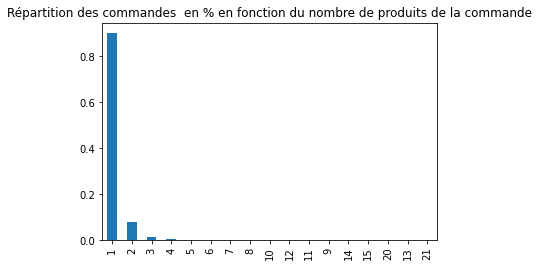

In [101]:
# affichage barplot
nb_achat['order_id'].value_counts(normalize=True).plot(kind='bar')
plt.title("Répartition des commandes  en % en fonction du nombre de produits de la commande")
plt.show() # Affiche le graphique


La majorité des commandes ne comporte qu'un seul produit. 

### 2.1 calcul de la récence

le temps écoulé depuis le dernier achat

In [102]:
r_ = df.groupby(by='customer_unique_id',
                        as_index=False)['order_purchase_timestamp'].max()
r_.columns = ['customer_unique_id', 'last_purchase_date']
recent_date = r_['last_purchase_date'].max()
r_['recency'] = r_['last_purchase_date'].apply(
    lambda x: (recent_date - x).days)
r_.sort_values(by='recency',ascending=True).head()

,customer_unique_id,last_purchase_date,recency
66809,b701bebbdf478f5500348f03aff62121,2018-08-29 14:52:00,0
71658,c45221bb4573f66bdd4daf43fe2d4b3b,2018-08-28 19:27:43,0
20005,36a5c01d940c382346247b3e6c485c2d,2018-08-28 22:51:54,0
61029,a712a430955027da5bc257a10073a390,2018-08-28 21:56:30,0
91700,fb7e29c65321441231990afc201c1b14,2018-08-28 19:32:05,0


### 2.2 Calcul de la fréquence  
Nous pouvons calculer la fréquence des achats des clients 

In [103]:
f_ = df.groupby(
    by=['customer_unique_id'], as_index=False)['order_id'].count()
f_.columns = ['customer_unique_id', 'frequency']
f_.sort_values(by='frequency',ascending=False).head()

,customer_unique_id,frequency
73112,c8460e4251689ba205045f3ea17884a1,24
25304,4546caea018ad8c692964e3382debd19,21
71552,c402f431464c72e27330a67f7b94d4fb,20
38573,698e1cf81d01a3d389d96145f7fa6df8,20
5622,0f5ac8d5c31de21d2f25e24be15bbffb,18


### 2.3 Calcul du montant

nous pouvons calculer le montant des achats des clients chez Olist

In [104]:
m_ = df.groupby(by='customer_unique_id', as_index=False)['price'].sum()
m_.columns = ['customer_unique_id', 'monetary_value']
m_.sort_values(by='monetary_value',ascending=False).head()

,customer_unique_id,monetary_value
3724,0a0a92112bd4c708ca5fde585afaa872,13440.0
79617,da122df9eeddfedc1dc1f5349a1a690c,7388.0
43161,763c8b1c9c68a0229c42c9fc6f662b93,7160.0
80444,dc4802a71eae9be1dd28f5d788ceb526,6735.0
25431,459bef486812aa25204be022145caa62,6729.0


### 2.4 dataframe RFM

je vais fusionner les dataframes

In [105]:
rfm_ = r_.merge(f_, on='customer_unique_id').merge(m_,on='customer_unique_id').drop(columns='last_purchase_date')
rfm_.head()


,customer_unique_id,recency,frequency,monetary_value
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,18.90
2,0000f46a3911fa3c0805444483337064,536,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,320,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,287,1,180.00


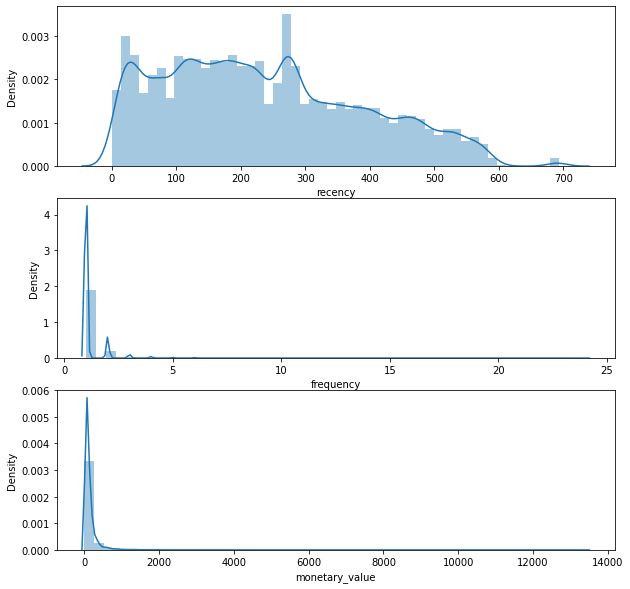

In [108]:
# Tracer les distributions RFM
plt.figure(figsize=(10,10))
# Distribution de recency
plt.subplot(3, 1, 1); sns.distplot(rfm_['recency'])
# Distribution de frequency
plt.subplot(3, 1, 2); sns.distplot(rfm_['frequency'])
# Distribution de  monetary_value 
plt.subplot(3, 1, 3); sns.distplot(rfm_['monetary_value'])
# Afficher 
plt.show()

In [109]:
rfm_['r_rank'] = rfm_['recency'].rank(ascending=False)
rfm_['f_rank'] = rfm_['frequency'].rank(ascending=True)
rfm_['m_rank'] = rfm_['monetary_value'].rank(ascending=True)
 
# normaliser le rang des clients
rfm_['r_rank_norm'] = (rfm_['r_rank']/rfm_['r_rank'].max())*100
rfm_['f_rank_norm'] = (rfm_['f_rank']/rfm_['f_rank'].max())*100
rfm_['m_rank_norm'] = (rfm_['m_rank']/rfm_['m_rank'].max())*100
 
rfm_.drop(columns=['r_rank', 'f_rank', 'm_rank'], inplace=True)
rfm_['tot_rank'] =round((rfm_['r_rank_norm']+rfm_['m_rank_norm']+rfm_['f_rank_norm'])/3,0)
rfm_.sort_values(by='frequency',ascending=False).head()

,customer_unique_id,recency,frequency,monetary_value,r_rank_norm,f_rank_norm,m_rank_norm,tot_rank
73112,c8460e4251689ba205045f3ea17884a1,21,24,4080.00,95.487666,100.000000,99.987143,98.0
25304,4546caea018ad8c692964e3382debd19,408,21,31.80,16.341806,99.998929,14.920288,44.0
71552,c402f431464c72e27330a67f7b94d4fb,187,20,2000.00,57.212126,99.997322,99.848933,86.0
38573,698e1cf81d01a3d389d96145f7fa6df8,371,20,1974.00,21.430102,99.997322,99.799649,74.0
5622,0f5ac8d5c31de21d2f25e24be15bbffb,275,18,1252.35,37.554382,99.995714,99.351804,79.0


In [110]:
# autre façon de faire le ranking
#Creer labels pour monetary_value
m_labels = range(1, 6);r_labels = range(5, 0, -1);f_labels = range(1, 6)
#Assigner les labels aux 5 groupes 
m_groups = pd.qcut(rfm_['monetary_value'], q=5, labels=m_labels)
r_groups = pd.qcut(rfm_['recency'], q=5, labels=r_labels)
f_groups = pd.qcut(rfm_['frequency'].rank(method='first'), q=5, labels=f_labels)
# assigner les valeurs aux nouvelles colonnes R,F,M
rfm_ = rfm_.assign(R = r_groups.values, F = f_groups.values,M = m_groups.values)
# concatener R,F,M pour créer la segmentation
rfm_[['R','F','M']] = rfm_[['R','F','M']].astype(str)
rfm_['RFM']=(rfm_.R+rfm_.F+rfm_.M).astype(int)
rfm_['RFM_score']= round((rfm_['R'].astype(int)+rfm_['F'].astype(int)+rfm_['M'].astype(int))/3,1)
rfm_.sort_values(by='RFM_score',ascending=True).head()

,customer_unique_id,recency,frequency,monetary_value,r_rank_norm,f_rank_norm,m_rank_norm,tot_rank,R,F,M,RFM,RFM_score
20532,381917c1951b8e044dd51544f465db6d,526,1,31.00,4.338205,43.782678,14.843683,21.0,1,1,1,111,1.0
5923,1019ed18792a025e05472c55766c34a0,428,1,24.90,13.962946,43.782678,8.742072,22.0,1,1,1,111,1.0
19731,35e32af235030874a6b6ccf5f328e8ac,420,1,35.99,14.820728,43.782678,17.867704,25.0,1,1,1,111,1.0
13581,25126926be8dbdb3264285caa7d0c40c,438,1,39.90,13.066051,43.782678,20.240850,26.0,1,1,1,111,1.0
19788,36023a7f667578e554e3a308c9d17598,449,1,39.90,11.800540,43.782678,20.240850,25.0,1,1,1,111,1.0


In [111]:
rfm_[['recency','frequency','monetary_value']].describe()

,recency,frequency,monetary_value
count,93336.000000,93336.000000,93336.000000
mean,236.899792,1.180370,141.622134
std,152.545336,0.620885,215.714177
min,0.000000,1.000000,0.850000
25%,113.000000,1.000000,47.650000
50%,218.000000,1.000000,89.700000
75%,345.000000,1.000000,154.712500
max,694.000000,24.000000,13440.000000


In [112]:
print("Le nombre de clients avec une commande unique  est de : {:.2f} %"
      .format(100*sum(rfm_["frequency"] == 1)/len(rfm_)))

Le nombre de clients avec une commande unique  est de : 87.56 %


### 2.5 Segmentation des clients

In [113]:
 rfm_['client_segment']= np.where(rfm_['RFM_score'] >
                                     4.5, "***** Top Customer",
                                      (np.where(
                                        rfm_['RFM_score'] > 4,
                                        "**** High value Customer",
                                        (np.where(
                                            rfm_['RFM_score'] > 3,
                             "*** Medium Value Customer",
                             np.where(rfm_['RFM_score'] > 1.5,
                            '** Low Value Customer ', '* Lost Customer'))))))

In [114]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_segment = rfm_.groupby('client_segment').agg({
    'recency': ['mean'],
    'frequency': ['min','mean','max'],
    'monetary_value': ['mean', 'count','sum']
}).round(1)

rfm_segment

recency frequency          monetary_value         \
                             mean       min mean max           mean  count   
client_segment                                                               
* Lost Customer             436.0         1  1.0   1           33.1   3440   
** Low Value Customer       281.4         1  1.0  21           92.1  50810   
*** Medium Value Customer   179.8         1  1.3  20          191.2  30502   
**** High value Customer    115.6         1  1.6  20          261.8   4755   
***** Top Customer           73.3         1  2.1  24          351.5   3829   

                                      
                                 sum  
client_segment                        
* Lost Customer             113984.4  
** Low Value Customer      4681185.7  
*** Medium Value Customer  5832548.8  
**** High value Customer   1244900.9  
***** Top Customer         1345823.8

In [115]:
rfm_segment.to_pickle('C:\\Users\\serge\\OneDrive\\Documents\\Documents\\DATA SCIENTIST\\P5\\rfm_segment.pkl')

### 2.6 Panier moyen et nombre d'achats par catégorie d'acheteurs

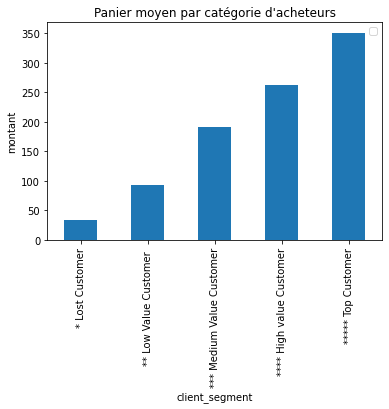

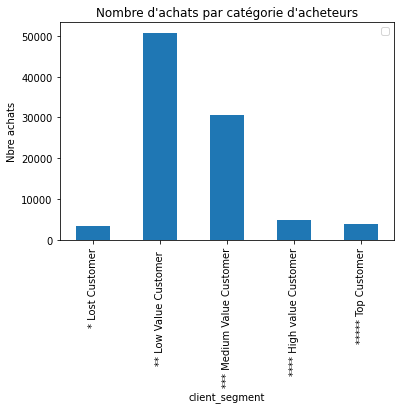

In [116]:

rfm_.groupby('client_segment').agg({
    'monetary_value': 'mean'}).plot(kind='bar')
plt.title("Panier moyen par catégorie d'acheteurs")
plt.ylabel('montant')
plt.legend("")

rfm_.groupby('client_segment').agg({
    'monetary_value': 'count'}).plot(kind='bar')
plt.title("Nombre d'achats par catégorie d'acheteurs")
plt.ylabel("Nbre achats")
plt.legend("")
plt.show()

### 2.7 Ajout de variables temporelles 

Je crée les colonnes  mois ,année et mois-année pour suivre l'évolution des ventes.

In [117]:
df['date']=df['order_purchase_timestamp'].dt.date
df['mois']=df['order_purchase_timestamp'].dt.month
df['annee']=df['order_purchase_timestamp'].dt.year
df['mois_an']=df['order_purchase_timestamp'].dt.to_period('M')

afin de vérifier si les achats varient dans la journée, je divise la journée en 4 tranches de 06h00

In [118]:
df['plage_horaire'] = ((df['order_purchase_timestamp'].dt.hour)/6+1).astype(int) # extraire l'heure et transformer en plage horaire
df['plage_horaire'].replace([1, 2,3,4], ['00:00-06:00','06:00-12:00','12:00-18:00','18:00-24:00'], inplace=True)
df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_purchase_timestamp,order_delivered_customer_date,order_item_id,product_id,price,freight_value,payment_sequential_nbre,payment_installments_sum,note,score,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,date,mois,annee,mois_an,plage_horaire
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,2017-05-25 10:35:35,1,a9516a079e37a9c9c36b9b78b10169e8,124.99,21.88,1,2,True,4.0,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,2017-05-16,5,2017,2017-05,12:00-18:00
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,2018-01-29 12:41:19,1,4aa6014eceb682077f9dc4bffebc05b0,289.00,46.48,1,8,True,5.0,utilidades_domesticas,43.0,1002.0,3.0,10150.0,89.0,15.0,40.0,2018-01-12,1,2018,2018-01,18:00-24:00
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45,2018-06-14 17:58:51,1,bd07b66896d6f1494f5b86251848ced7,139.94,17.79,1,7,True,5.0,moveis_escritorio,55.0,955.0,1.0,8267.0,52.0,52.0,17.0,2018-05-19,5,2018,2018-05,12:00-18:00
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,2018-03-13 16:06:38,2018-03-28 16:04:25,1,a5647c44af977b148e0a3a4751a09e2e,149.94,23.36,1,1,True,5.0,moveis_escritorio,48.0,1066.0,1.0,12160.0,56.0,51.0,28.0,2018-03-13,3,2018,2018-03,12:00-18:00
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 09:51:30,2018-08-09 20:55:48,1,9391a573abe00141c56e38d84d7d5b3b,230.00,22.25,1,8,True,5.0,casa_conforto,61.0,407.0,1.0,5200.0,45.0,15.0,35.0,2018-07-29,7,2018,2018-07,06:00-12:00



Je crée une variable traitement qui représente la durée du traitement d'une commande (temps entre la commande sur le site et la livraison chez le client)

In [119]:

df['traitement']=(df['order_delivered_customer_date']-df['order_purchase_timestamp'])/timedelta(days=1)


### 2.8 Chiffre d'affaire annuel 

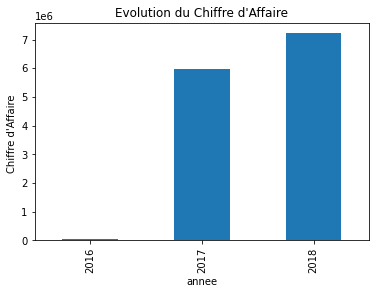

In [120]:
can=df['price'].groupby(df['annee']).sum()
plt.xlabel("Année")
plt.ylabel("Chiffre d\'Affaire ")
plt.title('Evolution du Chiffre d\'Affaire')
can.plot(kind='bar')
plt.show()

### 2.9 Suivi  des ventes 

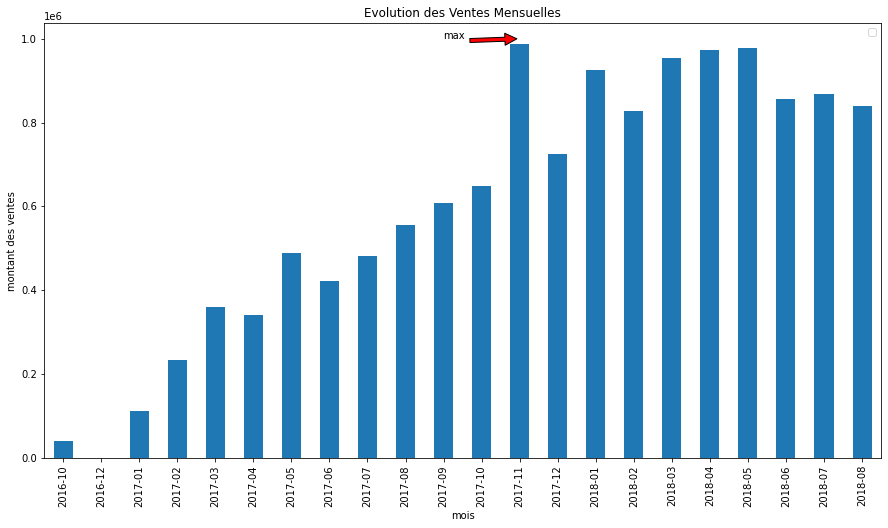

In [121]:
plt.figure(figsize=(15,8))
df.groupby('mois_an').sum()['price'].plot(kind='bar')
plt.annotate('max', xy=(12,1000000), xytext=(10,1000000), 
arrowprops={'facecolor':'red', 'shrink':0.05} )
plt.xlabel("mois")
plt.ylabel("montant des ventes")
plt.title('Evolution des Ventes Mensuelles')
plt.legend('') 
plt.show()

Les ventes ont progressé rapidement jusqu'à un maximum atteint en novembre 2017. Depuis juin 2018,la tendance est en légère baisse.

### 2.10 Evolution des ventes et tendance.

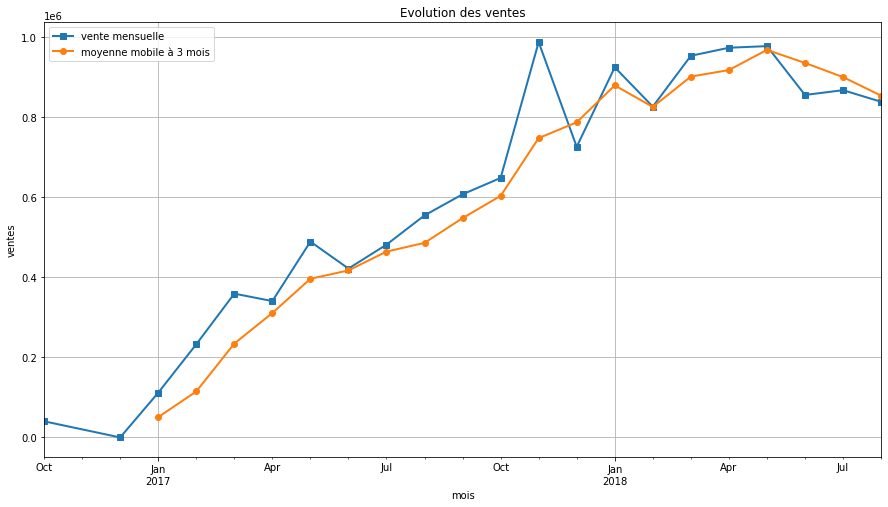

In [122]:
plt.figure(figsize=(15,8))
df.groupby('mois_an').sum()['price'].plot(kind='line',label = 'vente mensuelle',linewidth=2,marker="s" )
df.groupby('mois_an').sum()['price'].rolling(3).mean().plot(kind='line',label = 'moyenne mobile à 3 mois',linewidth=2,marker="o")
plt.legend()
plt.grid()
plt.xlabel("mois")
plt.ylabel("ventes")
plt.title('Evolution des ventes')
plt.show()

### 2.11 Evolution des ventes par segmentation clients

In [123]:
df=df.merge(rfm_.iloc[:,[0,1,2,3,11,12,13]],on="customer_unique_id",how="left")

In [124]:
df.head(5)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_purchase_timestamp,order_delivered_customer_date,order_item_id,product_id,price,freight_value,payment_sequential_nbre,payment_installments_sum,note,score,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,date,mois,annee,mois_an,plage_horaire,traitement,recency,frequency,monetary_value,RFM,RFM_score,client_segment
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,2017-05-25 10:35:35,1,a9516a079e37a9c9c36b9b78b10169e8,124.99,21.88,1,2,True,4.0,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,2017-05-16,5,2017,2017-05,12:00-18:00,8.812500,469,1,124.99,134,2.7,** Low Value Customer
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,2018-01-29 12:41:19,1,4aa6014eceb682077f9dc4bffebc05b0,289.00,46.48,1,8,True,5.0,utilidades_domesticas,43.0,1002.0,3.0,10150.0,89.0,15.0,40.0,2018-01-12,1,2018,2018-01,18:00-24:00,16.661748,228,1,289.00,315,3.0,** Low Value Customer
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45,2018-06-14 17:58:51,1,bd07b66896d6f1494f5b86251848ced7,139.94,17.79,1,7,True,5.0,moveis_escritorio,55.0,955.0,1.0,8267.0,52.0,52.0,17.0,2018-05-19,5,2018,2018-05,12:00-18:00,26.077153,101,1,139.94,414,3.0,** Low Value Customer
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,2018-03-13 16:06:38,2018-03-28 16:04:25,1,a5647c44af977b148e0a3a4751a09e2e,149.94,23.36,1,1,True,5.0,moveis_escritorio,48.0,1066.0,1.0,12160.0,56.0,51.0,28.0,2018-03-13,3,2018,2018-03,12:00-18:00,14.998461,168,1,149.94,414,3.0,** Low Value Customer
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 09:51:30,2018-08-09 20:55:48,1,9391a573abe00141c56e38d84d7d5b3b,230.00,22.25,1,8,True,5.0,casa_conforto,61.0,407.0,1.0,5200.0,45.0,15.0,35.0,2018-07-29,7,2018,2018-07,06:00-12:00,11.461319,31,1,230.00,515,3.7,*** Medium Value Customer


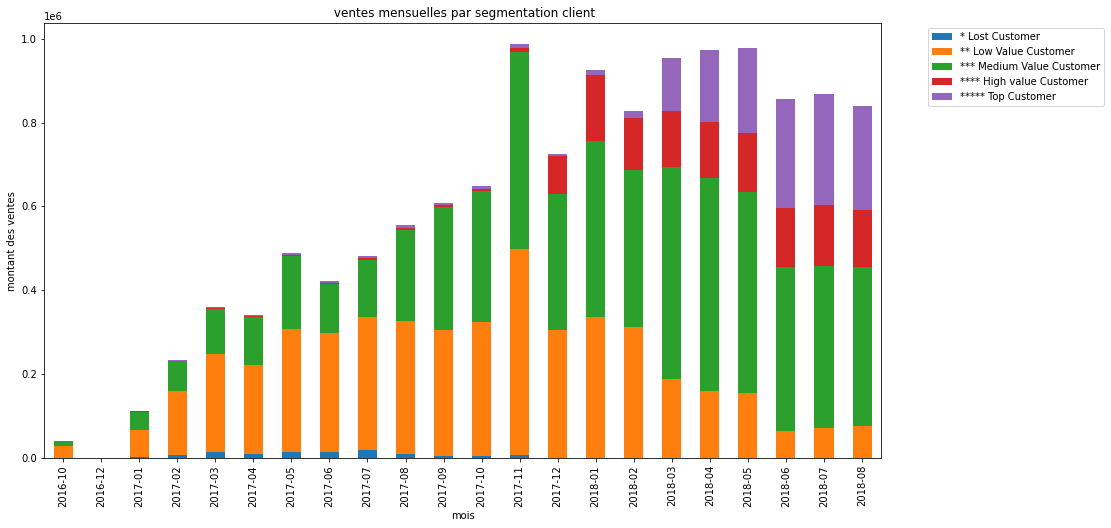

In [125]:

p=df.groupby(['mois_an','client_segment']).sum()['price'].unstack(level=1).plot(kind='bar',stacked=True)
plt.gcf().set_size_inches(15, 8)
#utiliser unstack(level = 1) pour afficher histogramme empilé avec mois_date en X
#utiliser unstack(level = 0) pour afficher histogramme empilé avec categ en X
# si unstack() pas utilisé , le graphe affichera  toutes le valeurs 
plt.xlabel("mois")
plt.ylabel("montant des ventes")
plt.title(' ventes mensuelles par segmentation client')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')  # position de la legende 
plt.show()


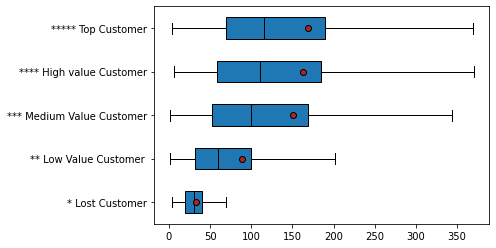

In [126]:
X = "client_segment" # qualitative
Y = "price" # quantitative

modalites = df.sort_values(by=['client_segment'])["client_segment"].unique()

groupes = []
for m in modalites:
    groupes.append(df[df[X]==m][Y])

# Propriétés graphiques     
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.show()

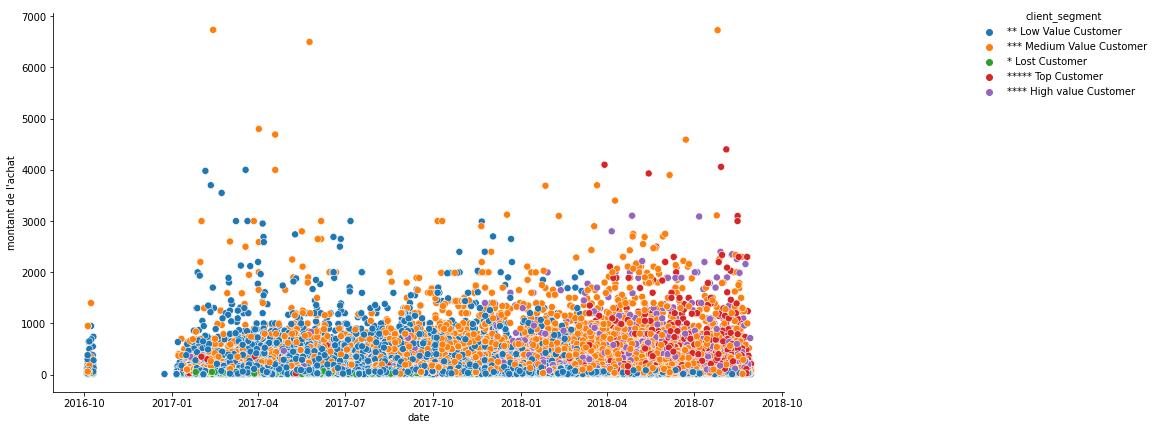

In [127]:
#plt.figure(figsize=(15,8))
gr=sns.relplot(x="order_purchase_timestamp",y="price",hue="client_segment",data=df,height=6,aspect=15/8,s=50) 
plt.xlabel("date")
plt.ylabel("montant de l'achat")
sns.move_legend(gr, "upper left", bbox_to_anchor=(1, 1))
plt.show()

### 2.12 lien entre la plage horaire et le nombre de commandes

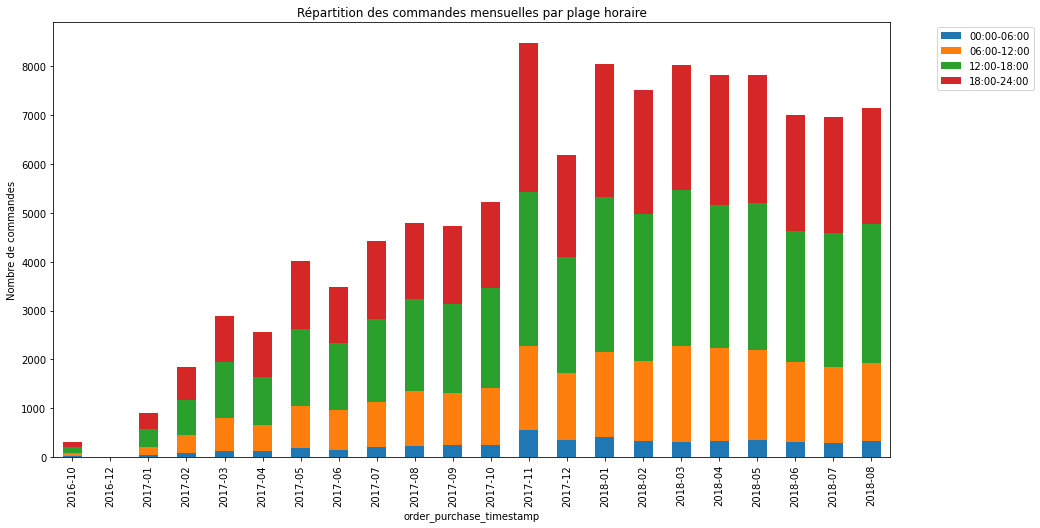

In [128]:

df.groupby(['mois_an','plage_horaire']).count()['order_id'].unstack(level=1).plot(kind='bar',stacked=True)
plt.xlabel("order_purchase_timestamp")
plt.ylabel("Nombre de commandes")
plt.title('Répartition des commandes mensuelles par plage horaire')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')  # position de la legende
plt.gcf().set_size_inches(15, 8)
plt.show()

Les commandes sont majoritairement passées entre 12h00 et 18h00 et entre 18h00 et 24h00. Il y a très peu de commandes passées la nuit.(typique d'un site vendant en local ) 

### 2.13 Répartition des achats par état de résidence des clients

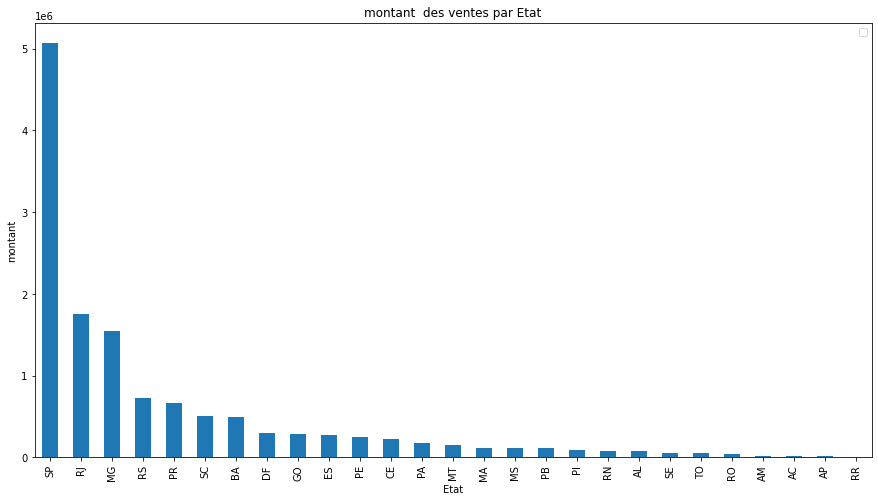

In [129]:
(df.groupby(['customer_state']).sum()['price']).sort_values(ascending=False).plot(kind='bar')
plt.xlabel("Etat")
plt.ylabel("montant")
plt.title('montant  des ventes par Etat')
plt.legend('')  
plt.gcf().set_size_inches(15, 8)
plt.show()

Sao Paulo  arrive très largement en tête des ventes

### 2.14 Catégorie client par état de résidence 

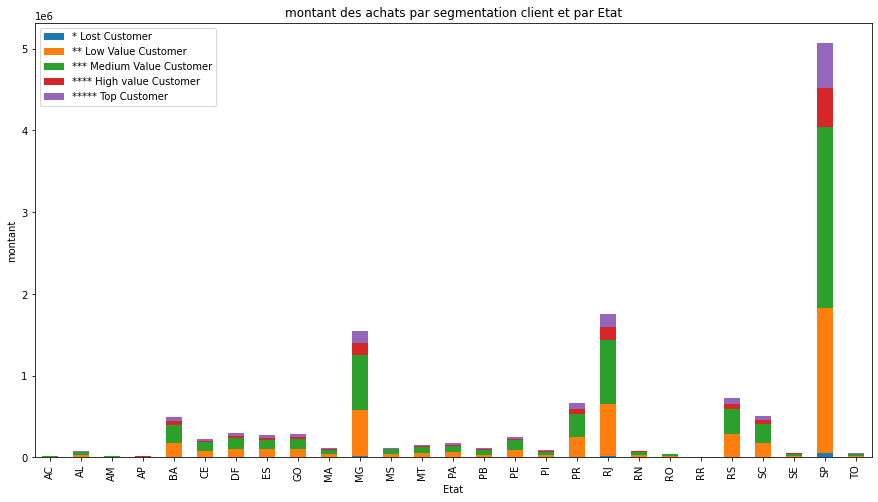

In [130]:
(df.groupby(['customer_state','client_segment']).sum()['price']).sort_values(ascending=False).unstack(level=1).plot(kind='bar',stacked=True)
plt.xlabel("Etat")
plt.ylabel("montant")
plt.title('montant des achats par segmentation client et par Etat')
plt.legend()  
plt.gcf().set_size_inches(15, 8)
plt.show()

### 2.15 Temps moyen de traitement d'une commande

In [131]:
print('Le temps moyen de traitement d\'une commande est de ',round(df['traitement'].mean(),0),'jours')
print('avec un écart type de ',round(df['traitement'].std(),1),"jours")

Le temps moyen de traitement d'une commande est de  12.0 jours
avec un écart type de  9.4 jours


In [132]:
df['traitement'].describe().round()

count    110171.0
mean         12.0
std           9.0
min           1.0
25%           7.0
50%          10.0
75%          16.0
max         210.0
Name: traitement, dtype: float64

In [133]:
print("nombre de jours maximum pour le traitement d'une commande :",round(df['traitement'].max(),0))
print("nombre de commandes dont le traitement a dépassé 100 jours :",df.loc[df['traitement']> 100].count()['order_id'])

nombre de jours maximum pour le traitement d'une commande : 210.0
nombre de commandes dont le traitement a dépassé 100 jours : 69


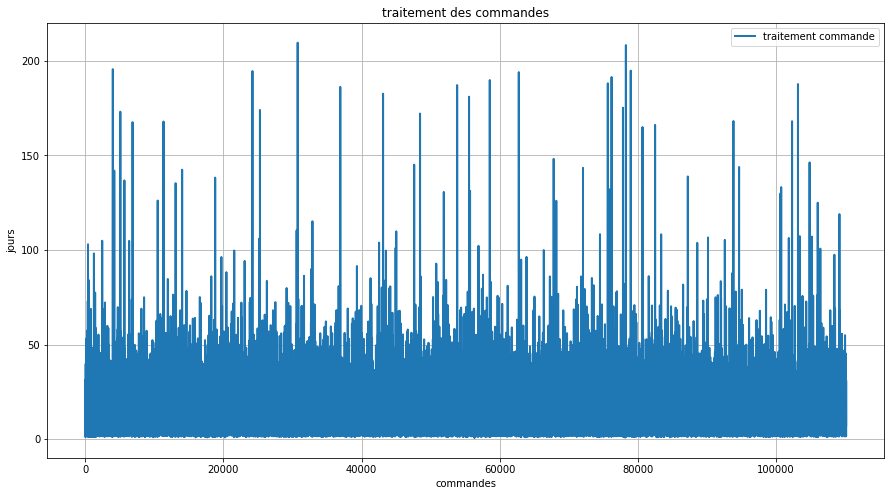

In [134]:
plt.figure(figsize=(15,8))
df['traitement'].plot(kind='line',label = 'traitement commande',linewidth=2 )
plt.legend()
plt.grid()
plt.xlabel("commandes")
plt.ylabel("jours")
plt.title('traitement des commandes')
plt.show()

On peut tracer un histogramme

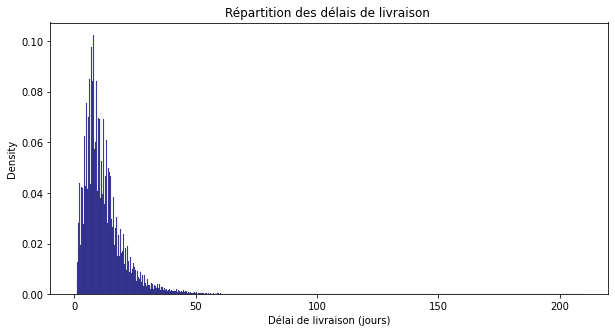

In [135]:
fig = plt.figure(figsize=(10, 5))
sns.histplot(data=df, x="traitement",
             stat="density",
             edgecolor="black",
             color="darkblue")
plt.xlabel("Délai de livraison (jours)")
plt.title("Répartition des délais de livraison ",
          )
plt.show()

<Axes: >

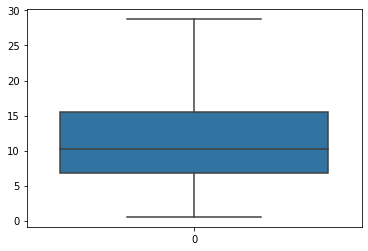

In [137]:
sns.boxplot(df["traitement"],showfliers=False)

<Axes: >

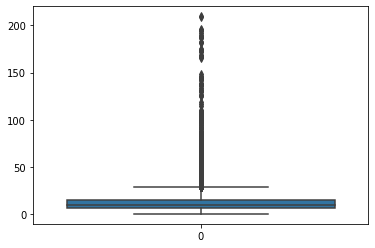

In [138]:
sns.boxplot(df["traitement"],showfliers=True)

### 2.16  Les commandes

> On peut regarder l'évolution du nombre de commandes par jour

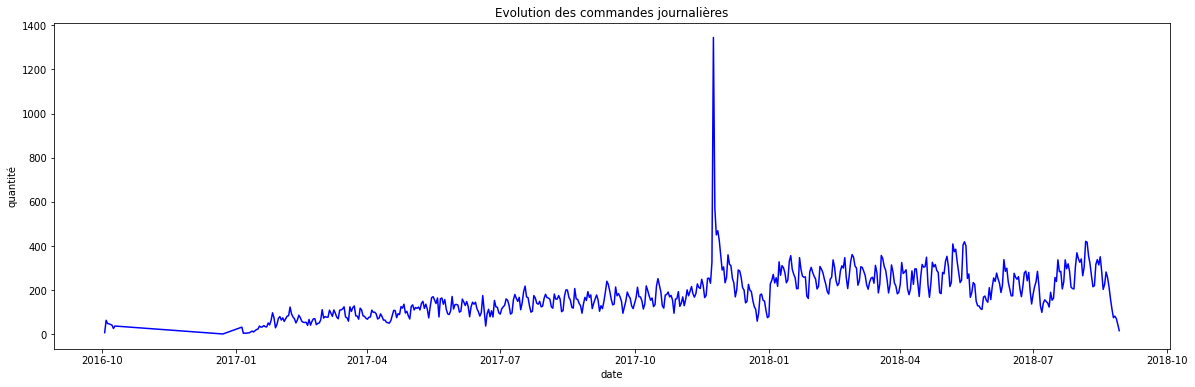

In [139]:
orders_day= df.groupby(df['date']).count()['order_id']
fig = plt.figure(figsize=(20, 6))
ax = orders_day.plot(color="blue")
ax.set_ylabel("quantité")
plt.title("Evolution des commandes journalières")
plt.show()

> On observe un pic très important dans le mois de novembre/décembre (fête ?)

On peut regarder l'évolution des commandes par mois

In [140]:
orders_day.describe()

count     611.000000
mean      180.312602
std       103.692019
min         1.000000
25%       110.000000
50%       167.000000
75%       243.500000
max      1345.000000
Name: order_id, dtype: float64

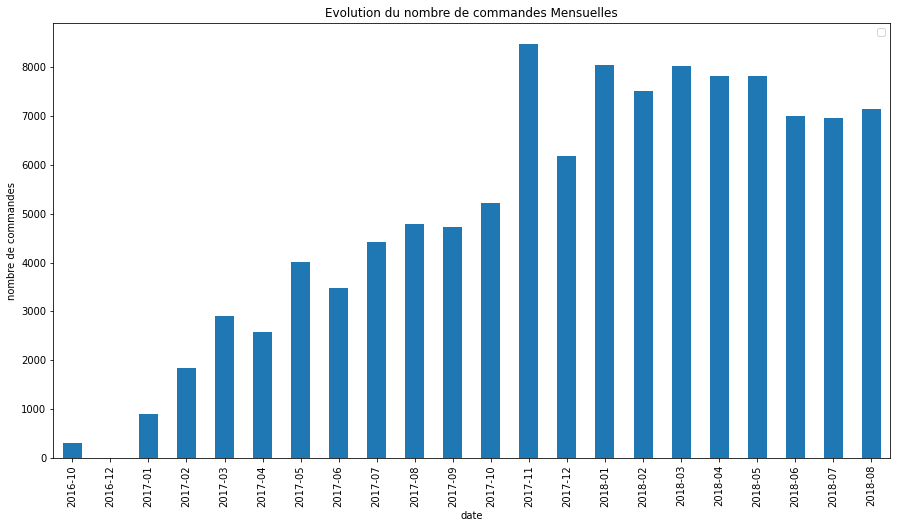

In [141]:
plt.figure(figsize=(15,8))
df.groupby('mois_an').count()['order_id'].plot(kind='bar')

plt.xlabel("date")
plt.ylabel("nombre de commandes")
plt.title('Evolution du nombre de commandes Mensuelles')
plt.legend('') 
plt.show()

On peut regarder si il y a des mois plus intéressants en terme de nombre de commandes 

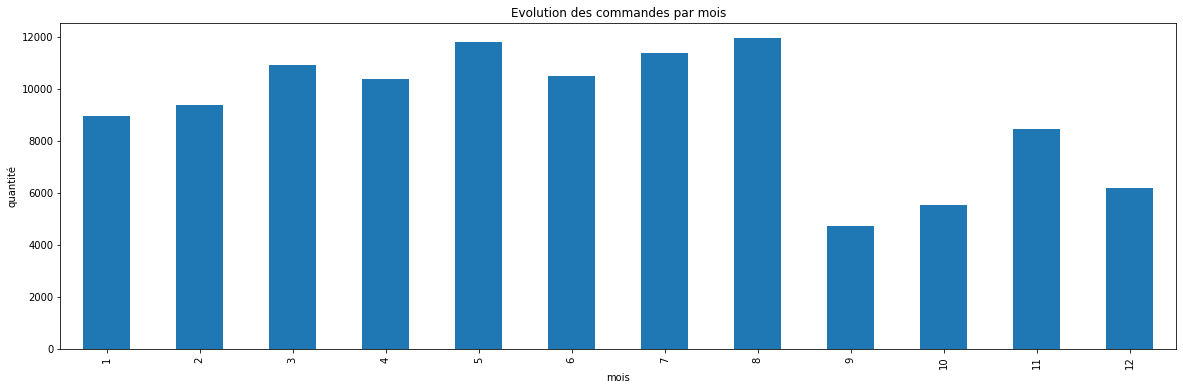

In [142]:
orders_month= df.groupby(df['mois']).count()['order_id']
fig = plt.figure(figsize=(20, 6))
ax = orders_month.plot(kind="bar",)
ax.set_ylabel("quantité")
plt.title("Evolution des commandes par mois")
plt.show()

Les commandes sont plus nombreuses dans les mois de mars à août.
On observe une chute assez marquée en 09 et 10 et cela remonte à partir de novembre (fêtes?)
Cela pourrait être une piste pour déterminer la période de mise à jour.

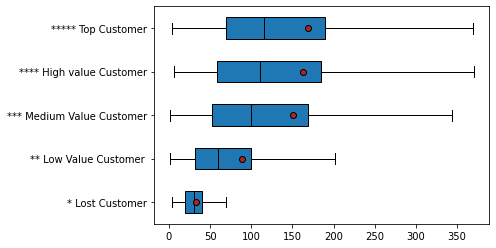

In [143]:
X = "client_segment" # qualitative
Y = "price" # quantitative

modalites = df.sort_values(by=['client_segment'])["client_segment"].unique()

groupes = []
for m in modalites:
    groupes.append(df[df[X]==m][Y])

# Propriétés graphiques     
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.show()

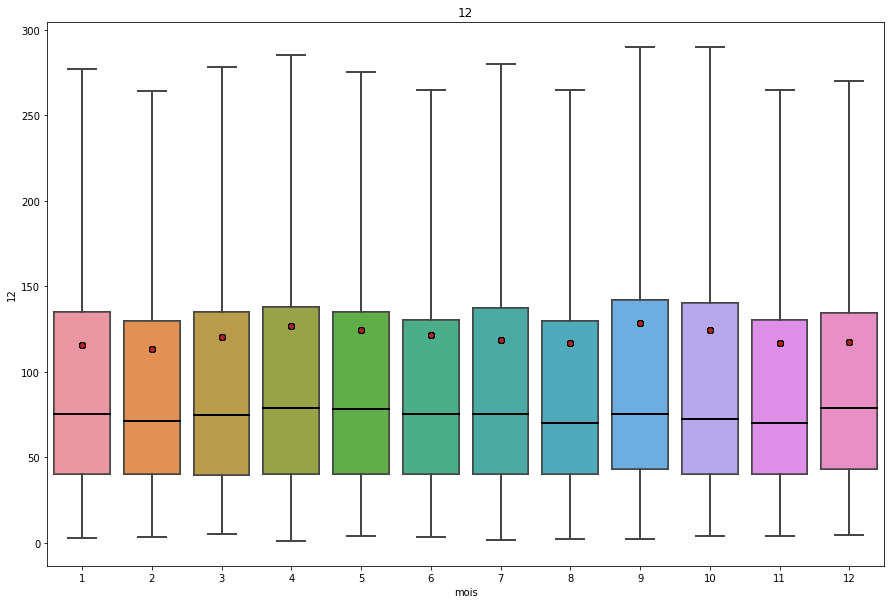

In [144]:
 plt.figure(figsize = (15,10))
for m in df['mois'].unique():
     
    # Propriétés graphiques     
    medianprops = {'color':"black"}
    meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    sns.boxplot( x=df['mois'],y=df['price'], showfliers=False,medianprops=medianprops, showmeans=True, meanprops=meanprops)
    plt.title(m)
    plt.ylabel(m)

    

Nous constatons que les médianes des différents mois sont très proches. Il en est de même pour les moyennes et les étendues.

On peut regarder si il y a des différences entre les jours de la semaine

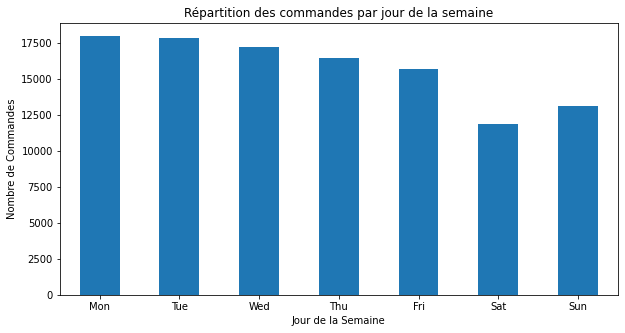

In [145]:
orders_weekday= df.groupby(df['order_purchase_timestamp'].dt.dayofweek).count()['order_id']
fig = plt.figure(figsize=(10, 5))
ax = orders_weekday.plot(kind="bar",                         
title="Répartition des commandes par jour de la semaine",
ylabel="Nombre de Commandes",
xlabel="Jour de la Semaine",
legend=False)
plt.xticks(np.arange(0,7), ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], rotation='horizontal')
plt.show()

Il y a moins de commandes les week-end. 

### 2.17 Catégories produits les plus présentes sur le site

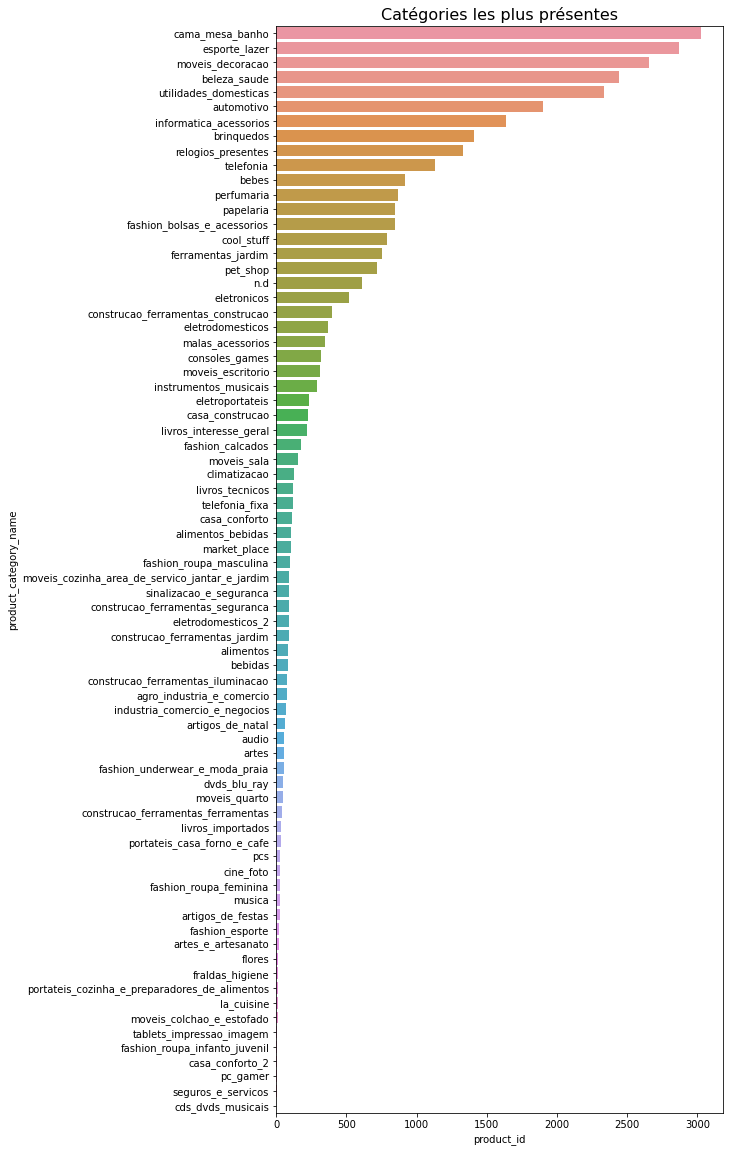

In [146]:
categ_top=products.groupby('product_category_name').count()[['product_id']].reset_index().sort_values(by='product_id', ascending=False)
plt.figure(figsize=(8,20))
sns.barplot(data=categ_top,x ='product_id',y='product_category_name' )
plt.title('Catégories les plus présentes',fontsize=16)
plt.show;

### 2.18 Les Paiements

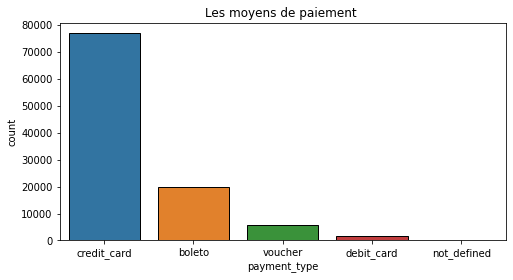

In [147]:
fig = plt.figure(figsize=(8, 4))
sns.countplot(data=payments, x="payment_type",
              edgecolor="black",
              )
plt.title("Les moyens de paiement ")
plt.show()

La plus grande partie des paiements s'effectue par carte de crédit


### 2.19 Les avis et notes des clients.

In [148]:
df['score'].describe()

count    109344.000000
mean          4.081614
std           1.347328
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: score, dtype: float64

In [149]:
df['score'].unique()

array([ 4.,  5.,  3., nan,  1.,  2.])

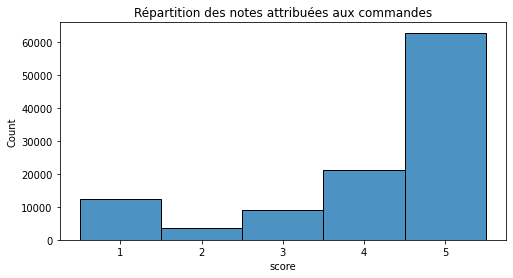

In [150]:
fig = plt.figure(figsize=(8, 4))
sns.histplot(data=df, x="score", 
             discrete=True,
              alpha=0.8)
plt.title("Répartition des notes attribuées aux commandes")
plt.show()

Les produits sont en majorité notés 5 (note max)

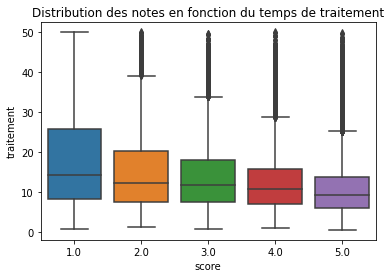

In [151]:
# Boîte à moustaches du temps de livraison pour chaque note
sns.boxplot(x="score", y="traitement",
            data=df[df["traitement"] < 50])
plt.title("Distribution des notes en fonction du temps de traitement")
plt.show()

Plus le traitement de la commande est rapide , plus la note laissée par le client est élevée


On peut regarder le nombre de notes laissées par les clients sur le site

<Axes: xlabel='note', ylabel='count'>

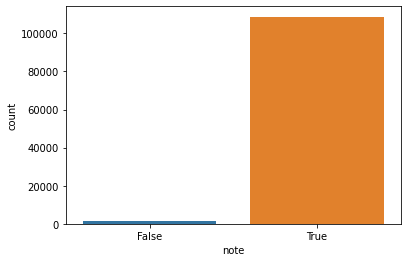

In [152]:
sns.countplot(x ='note', data = df)

In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110171 entries, 0 to 110170
Data columns (total 36 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    110171 non-null  object        
 1   customer_unique_id             110171 non-null  object        
 2   customer_zip_code_prefix       110171 non-null  int64         
 3   customer_city                  110171 non-null  object        
 4   customer_state                 110171 non-null  object        
 5   order_id                       110171 non-null  object        
 6   order_purchase_timestamp       110171 non-null  datetime64[ns]
 7   order_delivered_customer_date  110171 non-null  datetime64[ns]
 8   order_item_id                  110171 non-null  int64         
 9   product_id                     110171 non-null  object        
 10  price                          110171 non-null  float64       
 11  

In [154]:
df.isna().sum()

customer_id                        0
customer_unique_id                 0
customer_zip_code_prefix           0
customer_city                      0
customer_state                     0
order_id                           0
order_purchase_timestamp           0
order_delivered_customer_date      0
order_item_id                      0
product_id                         0
price                              0
freight_value                      0
payment_sequential_nbre            0
payment_installments_sum           0
note                               0
score                            827
product_category_name              0
product_name_lenght                0
product_description_lenght         0
product_photos_qty                 0
product_weight_g                   0
product_length_cm                  0
product_height_cm                  0
product_width_cm                   0
date                               0
mois                               0
annee                              0
m

On peut imputer les valeurs manquantes de score avec la valeur médian

In [155]:
df.fillna(df['score'].median(),inplace=True)

## 3 Création des jeux de données 

In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110171 entries, 0 to 110170
Data columns (total 36 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    110171 non-null  object        
 1   customer_unique_id             110171 non-null  object        
 2   customer_zip_code_prefix       110171 non-null  int64         
 3   customer_city                  110171 non-null  object        
 4   customer_state                 110171 non-null  object        
 5   order_id                       110171 non-null  object        
 6   order_purchase_timestamp       110171 non-null  datetime64[ns]
 7   order_delivered_customer_date  110171 non-null  datetime64[ns]
 8   order_item_id                  110171 non-null  int64         
 9   product_id                     110171 non-null  object        
 10  price                          110171 non-null  float64       
 11  

In [159]:
### dataset pour l 'actualisation de la segmentation'

maintenance=df[['customer_unique_id','score','order_purchase_timestamp','recency','frequency','monetary_value']]
maintenance.head()

,customer_unique_id,score,order_purchase_timestamp,recency,frequency,monetary_value
0,861eff4711a542e4b93843c6dd7febb0,4.0,2017-05-16 15:05:35,469,1,124.99
1,290c77bc529b7ac935b93aa66c333dc3,5.0,2018-01-12 20:48:24,228,1,289.00
2,060e732b5b29e8181a18229c7b0b2b5e,5.0,2018-05-19 16:07:45,101,1,139.94
3,259dac757896d24d7702b9acbbff3f3c,5.0,2018-03-13 16:06:38,168,1,149.94
4,345ecd01c38d18a9036ed96c73b8d066,5.0,2018-07-29 09:51:30,31,1,230.00


In [160]:
maintenance.to_csv('C:\\Users\\serge\\OneDrive\\Documents\\Documents\\DATA SCIENTIST\\P5\\maint.csv',index=False)

In [161]:
data=df.copy()

In [162]:
list_to_del=['customer_city','customer_state',"order_purchase_timestamp",
            'order_delivered_customer_date',"order_item_id","product_id","product_name_lenght",
             "product_description_lenght","product_photos_qty","product_weight_g",
             'product_length_cm','product_height_cm','product_width_cm','date','mois','annee',
             'mois_an','plage_horaire',"client_segment"
            ]

In [163]:
data.drop(columns=list_to_del,inplace=True)

On peut faire une jointure pour récupérer les coordonnées moyennes des villes

In [164]:
data=pd.merge(data, geos.iloc[:,0:3],how="left",
            left_on="customer_zip_code_prefix",right_on="geolocation_zip_code_prefix")

In [165]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110171 entries, 0 to 110170
Data columns (total 20 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   customer_id                  110171 non-null  object 
 1   customer_unique_id           110171 non-null  object 
 2   customer_zip_code_prefix     110171 non-null  int64  
 3   order_id                     110171 non-null  object 
 4   price                        110171 non-null  float64
 5   freight_value                110171 non-null  float64
 6   payment_sequential_nbre      110171 non-null  int64  
 7   payment_installments_sum     110171 non-null  int64  
 8   note                         110171 non-null  bool   
 9   score                        110171 non-null  float64
 10  product_category_name        110171 non-null  object 
 11  traitement                   110171 non-null  float64
 12  recency                      110171 non-null  int64  
 13 

In [166]:
data.loc[~data['geolocation_zip_code_prefix'].isin(data['customer_zip_code_prefix'])]

,customer_id,customer_unique_id,customer_zip_code_prefix,order_id,price,freight_value,payment_sequential_nbre,payment_installments_sum,note,score,product_category_name,traitement,recency,frequency,monetary_value,RFM,RFM_score,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng
391,ecb1725b26e8b8c458181455dfa434ea,b55a113bb84fc10eaf58c6d09ec69794,72300,8e806cca085990fdc8483aeb130d1330,56.99,14.15,1,3,True,5.0,perfumaria,21.471111,278,1,56.99,242,2.7,NaN,NaN,NaN
415,bcf86029aeed4ed8bac0e16eb14c22f5,7cd7974c9f79f75b77f323878ef87f43,11547,71932b1adae11f63e4a454bb85d4235a,54.90,10.99,1,1,True,1.0,brinquedos,24.521563,494,1,54.90,132,2.0,NaN,NaN,NaN
956,f4302056f0c58570522590f8181de2c7,67b05b597a66b5c449025000b9430abb,64605,d0bec96aad189992b278688279ba1511,99.90,0.00,1,4,True,5.0,relogios_presentes,12.668275,112,1,99.90,423,3.0,NaN,NaN,NaN
1319,03bbe0ce5c28e05f22917607db798818,8f3dca4306d5a89e4ae2c65c110603a2,72465,056349f85a73d794119c4286c95a52de,10.99,16.05,1,2,True,5.0,moveis_decoracao,13.937720,274,2,27.29,251,2.7,NaN,NaN,NaN
1389,ad4950aded55c2ea376be59506456d68,aa2b96dd03307ea6dc4b763c0b5f0b39,7729,17afedb7e5fad837f54bacf5c66c99f8,54.90,16.01,1,6,True,4.0,automotivo,9.438102,332,1,54.90,232,2.3,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107173,c348e5bd22ca24a447a221536c71d8b3,efe7f5948537f8e56c2c6b665cad9a34,12770,fd5c73fb6edc88486582bf0a0bb989aa,199.99,13.84,1,2,True,5.0,beleza_saude,8.276505,142,1,199.99,455,4.7,NaN,NaN,NaN
107962,cf818420383856a129134f5f8343f7b8,795c495a65f983b242fb01bd507977c5,72338,e13f9d9f79f8325d4f77d26e7384e9fd,44.90,14.10,1,1,True,5.0,brinquedos,13.353993,413,1,44.90,132,2.0,NaN,NaN,NaN
108707,f792e419335df11d82c32efcfb09c51b,c04c085b8e7573ba87b9ae1968d0985e,28530,84a80b02b3af075990fc7d9d2369f066,540.00,31.16,1,5,True,5.0,automotivo,18.648715,317,1,540.00,245,3.7,NaN,NaN,NaN
109546,78a11bb1fa72f556996b9a5b9bcd0629,e7536f62a200b415edd9491ac12a17fa,55863,19b6861ce084842fb4ec0cafc59deebe,39.99,37.04,1,7,True,5.0,telefonia,3.155093,106,1,39.99,442,3.3,NaN,NaN,NaN


In [167]:
data.nunique()

customer_id                    96455
customer_unique_id             93336
customer_zip_code_prefix       14889
order_id                       96455
price                           5859
freight_value                   6924
payment_sequential_nbre           19
payment_installments_sum          27
note                               2
score                              5
product_category_name             74
traitement                     93789
recency                          610
frequency                         19
monetary_value                  8465
RFM                              125
RFM_score                         13
geolocation_zip_code_prefix    14737
geolocation_lat                14737
geolocation_lng                14737
dtype: int64

In [168]:
df_cust=data.groupby('customer_unique_id').agg({"order_id": "count",
                  "price":"sum",
                   "freight_value":"sum" ,                            
                   "payment_sequential_nbre": "mean", 
                  "payment_installments_sum": "mean", 
                  "score": "mean",
                  "traitement": "mean","RFM_score":"mean",
                   "recency":"mean","frequency":'mean',"monetary_value":"mean",
                   "geolocation_lat":'mean','geolocation_lng':'mean'                      
                  })


In [169]:
df_cust=df_cust.rename(columns={'order_id':'nb_commandes','price':'total_price',
                                'freight_value':'total_freight_cost'})

In [170]:
df_cust.sort_values(by='total_price', ascending=False).head()

,nb_commandes,total_price,total_freight_cost,payment_sequential_nbre,payment_installments_sum,score,traitement,RFM_score,recency,frequency,monetary_value,geolocation_lat,geolocation_lng
customer_unique_id,,,,,,,,,,,,,
0a0a92112bd4c708ca5fde585afaa872,8,13440.0,224.08,1.0,1.0,1.0,18.123345,4.0,333,8,13440.0,-22.900792,-43.185126
da122df9eeddfedc1dc1f5349a1a690c,2,7388.0,183.63,1.0,10.0,5.0,15.869369,3.7,514,2,7388.0,-22.869018,-42.323247
763c8b1c9c68a0229c42c9fc6f662b93,4,7160.0,114.88,1.0,1.0,1.0,11.300949,5.0,45,4,7160.0,-20.368739,-40.307885
dc4802a71eae9be1dd28f5d788ceb526,1,6735.0,194.31,1.0,8.0,5.0,18.740069,3.3,562,1,6735.0,-20.484154,-54.570376
459bef486812aa25204be022145caa62,1,6729.0,193.21,1.0,1.0,5.0,20.866354,4.0,34,1,6729.0,-20.276227,-40.289945


In [171]:
df_cust.reset_index(inplace=True)

In [172]:
df_cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93336 entries, 0 to 93335
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_unique_id        93336 non-null  object 
 1   nb_commandes              93336 non-null  int64  
 2   total_price               93336 non-null  float64
 3   total_freight_cost        93336 non-null  float64
 4   payment_sequential_nbre   93336 non-null  float64
 5   payment_installments_sum  93336 non-null  float64
 6   score                     93336 non-null  float64
 7   traitement                93336 non-null  float64
 8   RFM_score                 93336 non-null  float64
 9   recency                   93336 non-null  int64  
 10  frequency                 93336 non-null  int64  
 11  monetary_value            93336 non-null  float64
 12  geolocation_lat           93082 non-null  float64
 13  geolocation_lng           93082 non-null  float64
dtypes: flo

Il y a des valeurs manquantes pour les coordonnées et le geolocation_zip_code_prefix. Je vais supprimer ces lignes

In [173]:
df_cust=df_cust.loc[df_cust['geolocation_lat'].notna()]
df_cust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93082 entries, 0 to 93335
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_unique_id        93082 non-null  object 
 1   nb_commandes              93082 non-null  int64  
 2   total_price               93082 non-null  float64
 3   total_freight_cost        93082 non-null  float64
 4   payment_sequential_nbre   93082 non-null  float64
 5   payment_installments_sum  93082 non-null  float64
 6   score                     93082 non-null  float64
 7   traitement                93082 non-null  float64
 8   RFM_score                 93082 non-null  float64
 9   recency                   93082 non-null  int64  
 10  frequency                 93082 non-null  int64  
 11  monetary_value            93082 non-null  float64
 12  geolocation_lat           93082 non-null  float64
 13  geolocation_lng           93082 non-null  float64
dtypes: flo

Pour exploiter au mieux les données je vais calculer la distance Haversine entre le siège de Olist et l état où réside le client ( latitude et longitude moyenne)

In [174]:
# Olist geolocalisation
olist_lat = -25.430182
olist_lon = -49.292507

In [175]:
def haversine_distance(lat1, lng1, lat2, lng2, degrees=True):
    r = 3956 # rayon de la Terre en miles
    
    if degrees:
        lat1, lng1, lat2, lng2 = map(radians, [lat1, lng1, lat2, lng2])
    
    # Formule Haversine
    dlng = lng2 - lng1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlng/2)**2
    d = 2 * r * asin(sqrt(a))  

    return d

In [176]:
# Haversine distance entre  et Olist HeadQuarter
df_cust['harvesine_distance'] = [haversine_distance(olist_lat, olist_lon, x, y) 
                              for x, y in zip(df_cust.geolocation_lat, 
                                              df_cust.geolocation_lng)]

In [177]:
df_cust.drop(columns=['geolocation_lat','geolocation_lng'],inplace=True)

In [178]:
df_cust.head()

,customer_unique_id,nb_commandes,total_price,total_freight_cost,payment_sequential_nbre,payment_installments_sum,score,traitement,RFM_score,recency,frequency,monetary_value,harvesine_distance
0,0000366f3b9a7992bf8c76cfdf3221e2,1,129.90,12.00,1.0,8.0,5.0,6.411227,3.0,111,1,129.90,211.605022
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,18.90,8.29,1.0,1.0,4.0,3.285590,2.0,114,1,18.90,203.565543
2,0000f46a3911fa3c0805444483337064,1,69.00,17.22,1.0,8.0,3.0,25.731759,1.3,536,1,69.00,151.433717
3,0000f6ccb0745a6a4b88665a16c9f078,1,25.99,17.63,1.0,4.0,4.0,20.037083,1.3,320,1,25.99,1666.067959
4,0004aac84e0df4da2b147fca70cf8255,1,180.00,16.89,1.0,6.0,5.0,13.141134,2.7,287,1,180.00,175.432978


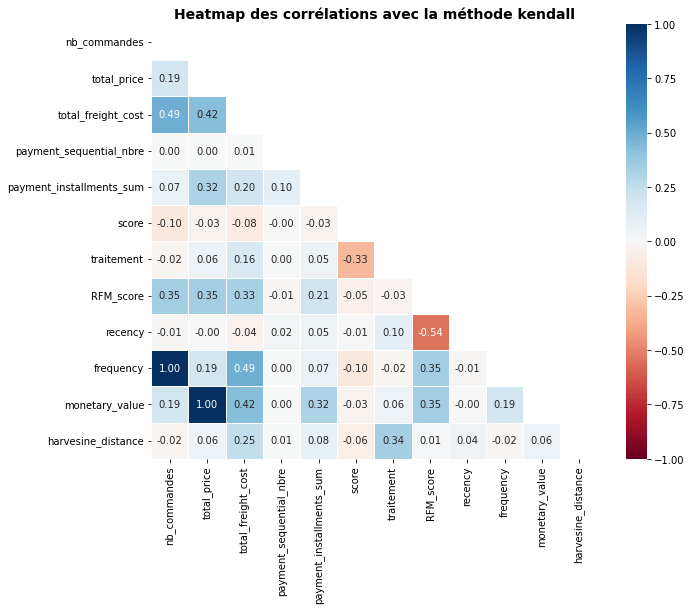

In [179]:
fi = plt.figure(figsize=(10, 8))
correlation_matrice(df_cust,'kendall')

Il y a deux corrélations parfaites entre frequency et nb_commandes  et  
entre monetary_value et total_price.
Je vais enlever nb_commandes et total_price  


In [180]:
df_cust.drop(columns=['nb_commandes','total_price'],inplace=True)

In [181]:
df_cust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93082 entries, 0 to 93335
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_unique_id        93082 non-null  object 
 1   total_freight_cost        93082 non-null  float64
 2   payment_sequential_nbre   93082 non-null  float64
 3   payment_installments_sum  93082 non-null  float64
 4   score                     93082 non-null  float64
 5   traitement                93082 non-null  float64
 6   RFM_score                 93082 non-null  float64
 7   recency                   93082 non-null  int64  
 8   frequency                 93082 non-null  int64  
 9   monetary_value            93082 non-null  float64
 10  harvesine_distance        93082 non-null  float64
dtypes: float64(8), int64(2), object(1)
memory usage: 8.5+ MB


In [182]:
df_cust.to_csv('C:\\Users\\serge\\OneDrive\\Documents\\Documents\\DATA SCIENTIST\\P5\\data.csv',index=False)